This notebook uses a new way of design William's Latin Square.

In [7]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Second order trial 1: <br>
    shuffle and build a latin square like first order, and then use this as a basic block to build 2nd order William's Latin Square.

In [19]:
import string
from random import shuffle

def new_will_latin(num, order, shuffle_q = False):
    """
    Parameters:
    ----------------
    
    num: numbers of treatments
    order: first order or second order
    shuffle_q: whether to shuffle rows of Latin square or not
    """
    letter_to_use = np.array(range(num))
    shuffle(letter_to_use)
    # Left and right part
    left_array = np.zeros([num, num])
    right_array = np.zeros([num, num])
    for i in range(num):
        correct_order = np.hstack((letter_to_use[i:], letter_to_use[:i]))
        left_array[i, :] = correct_order
        right_array[i, :] = correct_order[::-1]
        
    # Combine the left and right part to build the first order final latin square
    fo_final_array = np.zeros([num, num * 2]) # fo stands for first order
    for i in range(num):
        fo_final_array[:, 2 * i] = left_array[:, i]
        fo_final_array[:, 2 * i + 1] = right_array[:, i]
    
    right_fo_array = np.zeros([num, num * 2])
    final_array = np.zeros([num, num * 4])
    if "second" in order:
        for i in range(num):
            right_fo_array[i, :] = fo_final_array[i, :][::-1]
        for i in range(num * 2):
            final_array[:, 2 * i] = fo_final_array[:, i]
            final_array[:, 2 * i + 1] = right_fo_array[:, i]
    else: # First order
        final_array = fo_final_array
            
    
    # Write a function which could transfer an array to a string
    def transfer(arr):
        """
        Parameters:
        ----------------
    
        arr: the array to transfer
        """
        all_letters = string.ascii_uppercase
        arr_to_transfer = arr.flatten()
        seq = ""
        for i in arr_to_transfer:
            seq += all_letters[int(i)]
        
        return seq
    
    # Now we need to consider the given number is even or odd
    if num % 2 == 0:
        left_part = final_array[:, 0:num]
        right_part = final_array[:, num:]
        # Check the shuffle_q condition
        if shuffle_q == True:
            np.random.shuffle(left_part)
            np.random.shuffle(right_part)
            np.random.shuffle(final_array)
        return transfer(left_part), transfer(right_part), transfer(final_array)
    else: # odd
        if shuffle_q == True:
            np.random.shuffle(final_array)
        return transfer(final_array)

In [20]:
from itertools import product

def new_initiation(num_of_treatments, order_to_consider, shuffle_q = False):
    """
    Parameters:
    ----------------
    
    num_of_treatments: numbers of single treatments (eg: [AB] is 2 and [ABC] is 3)
    order_to_consider: consider second order or only first order
    shuffle_q: Same as the parameter in new_will_latin
    
    Return:
    ----------------
    var_dict: a dict indicating relationship between number and the sequenct it represent
    sequence: the sequence constructed by william's latin square
    """
    all_letters = string.ascii_uppercase
    total_comb = num_of_treatments ** 2 # if only consider first order
    if "second" in order_to_consider:
        total_comb = total_comb * num_of_treatments
        prods = product(all_letters[:num_of_treatments], repeat = 3)
    else:
        prods = product(all_letters[:num_of_treatments], repeat = 2)
    
    # Create a dictionary for storing variable name in latin square and the correspongding combination
    var_dict = {}
    index = 0
    for comb in prods:
        var_dict[index] = "".join(comb)
        index += 1
    
    # Construct william's latin square with the number calculated above and return the result
    # Also return the dict of the relationship between names and combinations
    return var_dict, new_will_latin(num_of_treatments, order_to_consider)

In [21]:
var_dict, seq = new_initiation(3, "first", shuffle_q = True)
real_seq = new_will_latin(3, "second", shuffle_q = True)
total_check({}, var_dict, "first", user_sequence = seq)

sequence is ACBBCABACCABCBAABC

AA's count is 1.0
AB's count is 3.0
AC's count is 2.0
BA's count is 2.0
BB's count is 1.0
BC's count is 3.0
CA's count is 2.0
CB's count is 2.0
CC's count is 1.0


True

In [13]:
def total_check(seq_dict, var_dict, order, to_shuffle = False, until = 0, user_sequence = "", to_print = True):
    """
    Parameters:
    ----------------
    seq_dict: the sequence dictionary to check
    var_dict: a dict indicating relationship between number and the sequenct it represent
    order: check first order or second order
    to_shuffle: whether to shuffle the dict or not, default is false
    until: check sequence until a given index, default is 0, meaning check all the sequence
    user_sequence: sometimes user want to manually add sequence, use this, default is "" meaning
                   use the seq_dict to construct sequence(to_shuffle must be false if use user sequence)
    to_print: whether to print details result, default is true
    
    Return:
    ----------------
    True if criterions met, False otherwise
    """
    # First construct sequence using seq_dict if no sequence given by user
    full_sequence = user_sequence
    if full_sequence == "":
        key_list = list(seq_dict.keys())
        if to_shuffle == True: # If to_shuffle is true, shuffle the keys so the rows of the latin square is random
            shuffle(key_list)
        for key in key_list:
            seq = seq_dict[key]
            for item in seq:
                full_sequence += var_dict[int(item)]
    
    # Now start to check sequence
    # First see if until is set, if yes, we take a subsequence of the original sequence
    if until != 0:
        full_sequence = full_sequence[:until]
    # Start to check
    if "second" in order: # Check second order
        criterion_count = np.zeros(len(list(var_dict.values())))
        criterions = list(var_dict.values())
        for i in range(len(full_sequence)):
            if i > 1:
                for j in range(len(criterions)):
                    if full_sequence[i-2:i+1] == criterions[j]:
                        criterion_count[j] += 1
        
        # If the difference between counts are trivial, consider true
        score_list = list(criterion_count)
        score_list.sort()
        
        # Construct a new var_dict for checking first order conditions
        new_var_dict = {}
        letters_used_set = set(list(full_sequence))
        letters = ""
        for item in letters_used_set:
            letters += item
        # Get first order vars
        prods = product(letters, repeat = 2)
        index = 0
        for comb in prods:
            new_var_dict[index] = "".join(comb)
            index += 1

        # Get and return result
        if score_list[0] == score_list[-1]:
            # Still need to check first order condition
            #return total_check({}, new_var_dict, "first", False, until, full_sequence, to_print = True)
            return total_check({}, new_var_dict, "first", False, until, full_sequence, to_print = False)
        elif (score_list[-1] - score_list[0]) / score_list[-1] <= 0.33:
            if to_print:
                for i in range(len(criterions)):
                    print("{}\'s count is {}".format(criterions[i], criterion_count[i]))
            #return total_check({}, new_var_dict, "first", False, until, full_sequence, to_print = True)
            return total_check({}, new_var_dict, "first", False, until, full_sequence, to_print = False)
        elif score_list[-1] <= 10 and score_list[0] != 0 and score_list[-1] - score_list[0] <= 2:
            if to_print:
                for i in range(len(criterions)):
                    print("{}\'s count is {}".format(criterions[i], criterion_count[i]))
            #return total_check({}, new_var_dict, "first", False, until, full_sequence, to_print = True)
            return total_check({}, new_var_dict, "first", False, until, full_sequence, to_print = False)
        else:
            if to_print:
                print(score_list[-1], score_list[0])
                print("sequence is {}".format(full_sequence))
                print()
                for i in range(len(criterions)):
                    print("{}\'s count is {}".format(criterions[i], criterion_count[i]))
            return False
    # Now check first order conditions
    else:
        criterion_count = np.zeros(len(list(var_dict.values())))
        criterions = list(var_dict.values())
        for i in range(len(full_sequence)):
            if i > 0:
                for j in range(len(criterions)):
                    if full_sequence[i-1:i+1] == criterions[j]:
                        criterion_count[j] += 1
        
        # If the difference between counts are similar, consider true
        score_list = list(criterion_count)
        score_list.sort()

        # Get and return result
        if score_list[0] == score_list[-1]:
            if to_print:
                print("sequence is {}".format(full_sequence))
                print()
            return True
        elif (score_list[-1] - score_list[0]) / score_list[-1] <= 0.25:
            if to_print:
                print("sequence is {}".format(full_sequence))
                print()
                for i in range(len(criterions)):
                    print("{}\'s count is {}".format(criterions[i], criterion_count[i]))
            return True
        elif score_list[-1] <= 10 and score_list[0] != 0 and score_list[-1] - score_list[0] <= 2:
            if to_print:
                print("sequence is {}".format(full_sequence))
                print()
                for i in range(len(criterions)):
                    print("{}\'s count is {}".format(criterions[i], criterion_count[i]))
            return True
        else:
            if to_print:
                print("sequence is {}".format(full_sequence))
                print()
                for i in range(len(criterions)):
                    print("{}\'s count is {}".format(criterions[i], criterion_count[i]))
            return False

In [5]:
def random_sequence(num, length):
    '''
    Parameter:
    ------------------------------
    
    num: same meaning as will_latin's num, e.g., if want AB, input 2, want ABC, input 3
    length: sequence length, meaning how long a sequence we want to build
    '''
    full_sequence = ""
    letters_needed = list(string.ascii_uppercase[:num])
    for i in range(length):
        full_sequence += random.choice(letters_needed)
    return full_sequence

In [6]:
def get_sequence(seq_dict,var_dict,length = 0):
    """
    Return a required length sequence to operate, also return if the sequence is good or not
    by using the function total_check
    
    Parameters:
    ----------------
    seq_dict: the sequence dictionary to check
    var_dict: a dict indicating relationship between number and the sequenct it represent
    length: provide a required length to consider, default is 0 which means whatever the length in seq_dict
    """
    # First construct sequence using seq_dict
    # if the sequence length is longer than the required length, cut it to the point, if not, reshuffle the
    # rows of latin square and add to the sequence
    full_sequence = ""
    key_list = list(seq_dict.keys())
    
    shuffle(key_list)
    for key in key_list:
        seq = seq_dict[key]
        for item in seq:
            full_sequence += var_dict[int(item)]
            
    if length != 0:
        while len(full_sequence) < length:
            shuffle(key_list)
            for key in key_list:
                seq = seq_dict[key]
                for item in seq:
                    full_sequence += var_dict[int(item)]
        full_sequence = full_sequence[:length]
    
    # Check the quality of this constructed sequence
    quality = total_check(seq_dict, var_dict, "second", user_sequence = full_sequence, to_print = False)
    
    return full_sequence, quality

In [10]:
# Consider the 3 treatments condition
# Take no consideration of interaction term for now
# Uses a new kind of design matrix different than other takes

def new_design_matrix_trt3(full_sequence):
    """
    Return a matrix containing treatment like:
        today       yesterday
    t   A  B  C    A  B  C 
    0   1  0  0    0  1  0
    1   0  1  0    1  0  0       
    2   0  0  1    0  1  0   
    .....
    .....
    
    Here we only consider three treatment types (A,B,C) and hence when t1 is using A, then the A column of t1
    will be 1 and B, C columns of t1 should all be 0.
    
    Still, as before, we don't consider the first day(it only shows up in the yesterday part, not today part).
    
    Parameter:
    ------------------
    full_seuqnce: the sequence to consider
    """
    seq_len = len(full_sequence)
    dm = np.zeros([seq_len - 1, 6])
    for i in range(seq_len):
        if i == 0: # The first element in the sequence
            if full_sequence[i] == "A":
                dm[i, 3] = 1
            elif full_sequence[i] == "B":
                dm[i, 4] = 1
            else:
                dm[i, 5] = 1
        elif i == seq_len - 1: # The last element in the sequence
            if full_sequence[i] == "A":
                dm[i - 1, 0] = 1
            elif full_sequence[i] == "B":
                dm[i - 1, 1] = 1
            else:
                dm[i - 1, 2] = 1
        else: # All the middle elements
            if full_sequence[i] == "A":
                dm[i - 1, 0] = 1
                dm[i, 3] = 1
            elif full_sequence[i] == "B":
                dm[i - 1, 1] = 1
                dm[i, 4] = 1
            else:
                dm[i - 1, 2] = 1
                dm[i, 5] = 1
    
    return dm

In [27]:
# A demo
dm = new_design_matrix_trt3("ABCABC")
dm

array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.]])

In [67]:
def new_get_y_trt3(alpha, beta, design_matrix, err_std = 1):
    """
    Take given parameter values and calculate y (response)
    Here alpha and beta are both 3-element vector, where alpha[1] represents A's treatment effect for today,
        and alpha[2], alpha[3] represents B and C respectively. Beta is similar but it represents yesterday.
    y_t = alpha * design_m[:,0:2] + beta * design_m[:,3:5]
    
    Parameters:
    -------------------
    alpha: parameter corresponding with current item
    beta: parameter corresponding with immediately previous item
    design_matrix: the matrix calculated by the design matrix function
    err_std: error term's standard deviation, default is 1. (error term is draw from a normal distribution
             with mean 0 and std the given value or 1 by default)
    """
    
    m, n = design_matrix.shape
    y = np.matmul(design_matrix[:, 0:3], alpha.reshape(3,1)) + np.matmul(design_matrix[:, 3:], beta.reshape(3,1)) \
        + np.random.normal(0, err_std, m).reshape(m, 1) # This is the err term
    
    return y

In [68]:
def experiment_trt3(alpha, beta, quality, err_std = 1, sample_size = 500):
    """
    Run an experiment and return dictionary containing beta values
    
    Parameters:
    -------------------
    quality: state what quality do you want for the experiment, "perfect" means all sample latin square need to
             pass the test, "alright" means the latin square samples that comes out from William's latin square, 
             "whatever" means random sequence, "ABAB" means a sequence containing ABABAB...
    sample_size: how many samples to draw, default is 1000
    other parameters similar as in other functions
    """
    
    seq_size_list = [81 + 81 * i for i in range(8)]
    
    alpha1_dict = {}
    alpha2_dict = {}
    alpha3_dict = {}
    beta1_dict = {}
    beta2_dict = {}
    beta3_dict = {}

    
    # Draw sample and calculate standard error of beta
    for seq_size in seq_size_list:
        count = 0
        alpha1_dict[seq_size] = []
        alpha2_dict[seq_size] = []
        alpha3_dict[seq_size] = []
        beta1_dict[seq_size] = []
        beta2_dict[seq_size] = []
        beta3_dict[seq_size] = []
        
        while count < sample_size:
            var_dict, seq_dict = initiation(3, "second")
            if "whatever" not in quality:
                r1, r2 = get_sequence(seq_dict, var_dict, seq_size)
                if r2 == True and "perfect" in quality:
                    dm = new_design_matrix_trt3(r1)
                    y = new_get_y_trt3(alpha, beta, dm, err_std = err_std)
                    al_betas,residuals,b,c = np.linalg.lstsq(dm, y, rcond = None) # a,b,c is other values the function returns
                                                                        # not important, so we use a,b,c
                    alpha1_dict[seq_size].append(al_betas[0])
                    alpha2_dict[seq_size].append(al_betas[1])
                    alpha3_dict[seq_size].append(al_betas[2])
                    beta1_dict[seq_size].append(al_betas[3])
                    beta2_dict[seq_size].append(al_betas[4])
                    beta3_dict[seq_size].append(al_betas[5])
                    count += 1
                elif "alright" in quality:
                    dm = new_design_matrix_trt3(r1)
                    y = new_get_y_trt3(alpha, beta, dm, err_std = err_std)
                    al_betas,residuals,b,c = np.linalg.lstsq(dm, y, rcond = None)
                    alpha1_dict[seq_size].append(al_betas[0])
                    alpha2_dict[seq_size].append(al_betas[1])
                    alpha3_dict[seq_size].append(al_betas[2])
                    beta1_dict[seq_size].append(al_betas[3])
                    beta2_dict[seq_size].append(al_betas[4])
                    beta3_dict[seq_size].append(al_betas[5])
                    count += 1
            else: # All random case
                sequence = random_sequence(3, seq_size)
                dm = new_design_matrix_trt3(sequence)
                y = new_get_y_trt3(alpha, beta, dm, err_std = err_std)
                al_betas,residuals,b,c = np.linalg.lstsq(dm, y, rcond = None)
                alpha1_dict[seq_size].append(al_betas[0])
                alpha2_dict[seq_size].append(al_betas[1])
                alpha3_dict[seq_size].append(al_betas[2])
                beta1_dict[seq_size].append(al_betas[3])
                beta2_dict[seq_size].append(al_betas[4])
                beta3_dict[seq_size].append(al_betas[5])
                count += 1
            
    return alpha1_dict, alpha2_dict, alpha3_dict, beta1_dict, beta2_dict, beta3_dict

In [69]:
def MSE(estimate_array, true_value):
    """
    Calculate mean standard error
    
    Parameters:
    -------------------
    estimate_array: a numpy array containing all estimated values of the true value
    true_value: the value to estimate
    """
    return np.mean((estimate_array - true_value) ** 2)

In [70]:
def draw_plot_trt3(alpha,beta, draw, err_std = 1,sample_size = 500):
    """
    Draw 3 plots:
    1. for standard error of betas
    2. mean value of beta hat and std
    3. MSE of beta hat
    
    Parameters:
    -------------------
    draw: which beta to draw, give 1, 2, 3, 4, 5, 6
    parameters similar as the above function
    """
    name_dict = {1:"alpha1", 2:"alpha2", 3: "alpha3", 4: "beta1", 5: "beta2", 6: "beta3"}
    fig, ax1 = plt.subplots(figsize = (15,10))
    fig, ax2 = plt.subplots(figsize = (15,10))
    fig, ax3 = plt.subplots(figsize = (15,10))
    fig, ax4 = plt.subplots(figsize = (15,10))
    quality_list = ["perfect", "alright", "whatever"] 
    for qu in quality_list:
        mean_list = []
        se_list = []
        mse_list = []
        reject_dict = {}
        result = experiment_trt3(alpha, beta, qu, err_std = err_std, sample_size = sample_size)
        coef_to_draw_dict = result[draw - 1]
        
        for key in coef_to_draw_dict:
            reject_dict[key] = 0
            for i in range(sample_size):
                if 1 - stats.t.cdf(coef_to_draw_dict[key][i] / np.std(coef_to_draw_dict[key]), df = key - 6) < 0.05:
                    reject_dict[key] += 1
                                   
            mean_list.append(np.mean(coef_to_draw_dict[key]))
            se_list.append(np.std(coef_to_draw_dict[key]))# / np.sqrt(sample_size))
            if draw <= 3: 
                mse_list.append(MSE(np.array(coef_to_draw_dict[key]), alpha[draw - 1]))
            else:
                mse_list.append(MSE(np.array(coef_to_draw_dict[key]), beta[draw - 4]))
        
        mean_std = np.array(se_list) / np.sqrt(sample_size)
        
        # Actual plotting
        # First plot
        ax1.plot(coef_to_draw_dict.keys(), se_list, label = "{}, {}".format(qu, name_dict[draw]))
        
        # Second plot
        ax2.plot(coef_to_draw_dict.keys(), mean_list, label = "{}, {}".format(qu, name_dict[draw]))
        ax2.fill_between(coef_to_draw_dict.keys(), np.array(mean_list) - mean_std, 
                        np.array(mean_list) + mean_std, alpha = 0.5)
        
        # Third plot
        ax3.plot(coef_to_draw_dict.keys(), mse_list, label = "{}, {}".format(qu, name_dict[draw]))
        ax4.plot(coef_to_draw_dict.keys(), reject_dict.values(), label = "{}, {}".format(qu, name_dict[draw]))
    ax1.set_title("Standard error with coef values {}, {}, err_std is {}".format(alpha,beta,err_std))
    ax1.legend()
    
    ax2.set_title("Mean value of beta hat and se with coef values {}, {}, err_std is {}".format(alpha,beta,err_std))
    if draw <= 3: 
        ax2.axhline(y = alpha[draw - 1], color='r', linestyle='-')
    else:
        ax2.axhline(y = beta[draw - 4], color='r', linestyle='-')
    ax2.legend()
    
    ax3.set_title("MSE with coef values {}, {}, err_std is {}".format(alpha,beta,err_std))
    ax3.legend()
        
    ax4.set_title("Rejected amount with coef values {}, {}, err_std is {}".format(alpha,beta,err_std))
    ax4.legend()
    
    plt.show()
    
    return coef_to_draw_dict

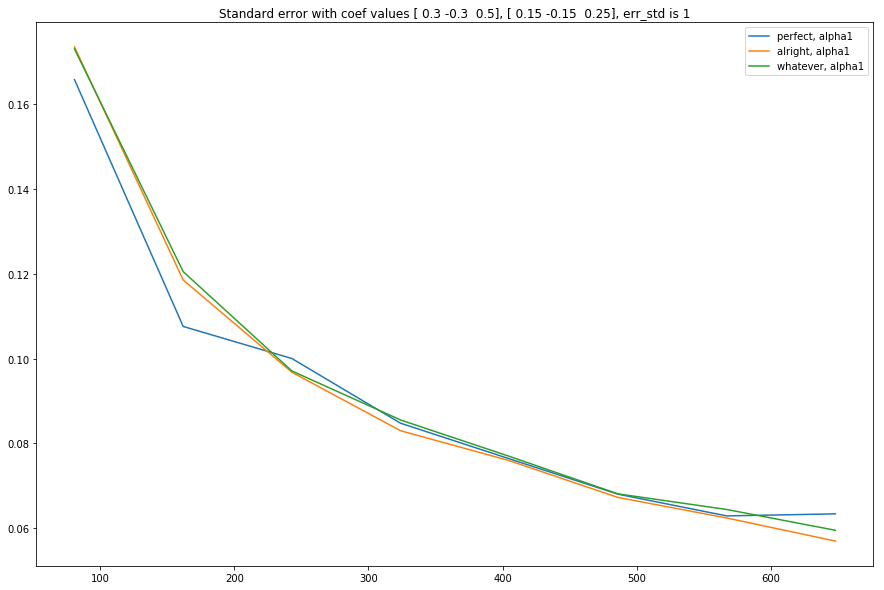

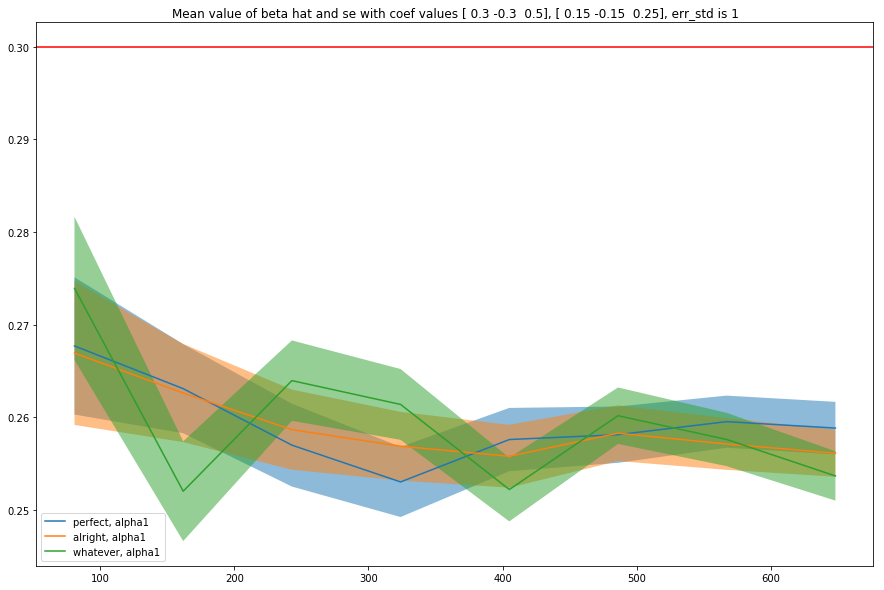

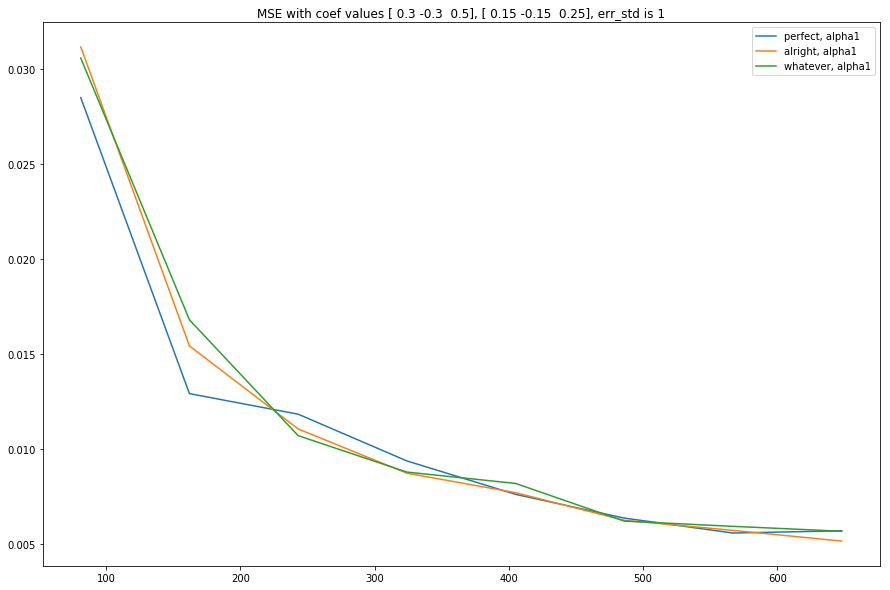

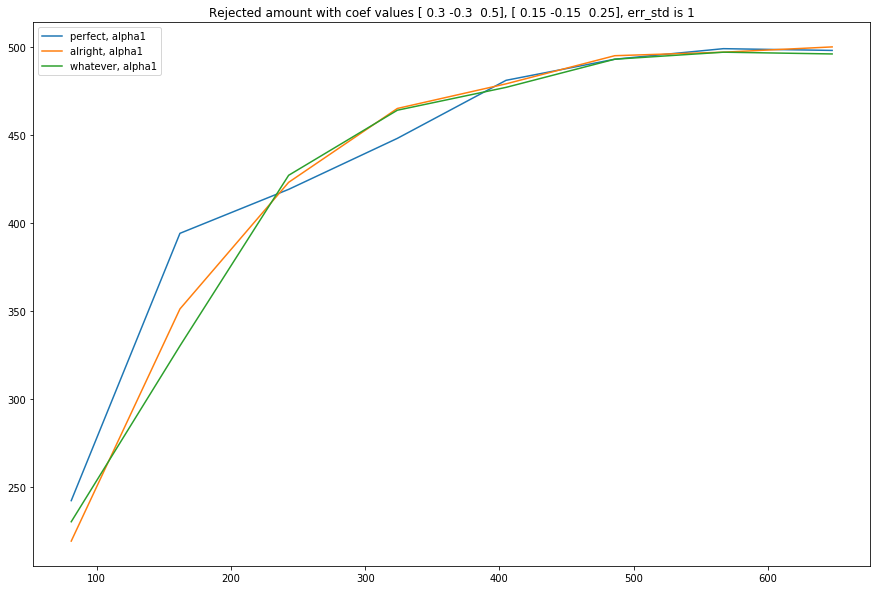

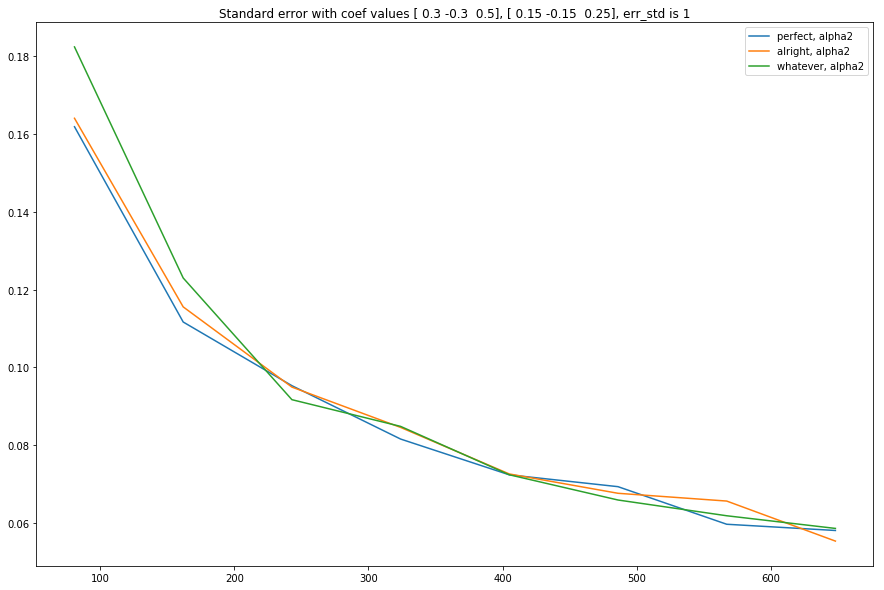

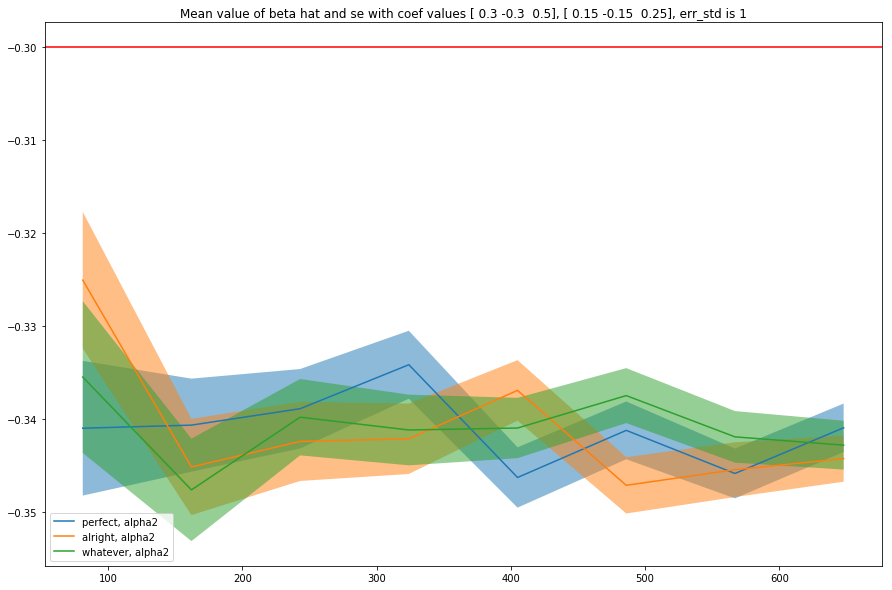

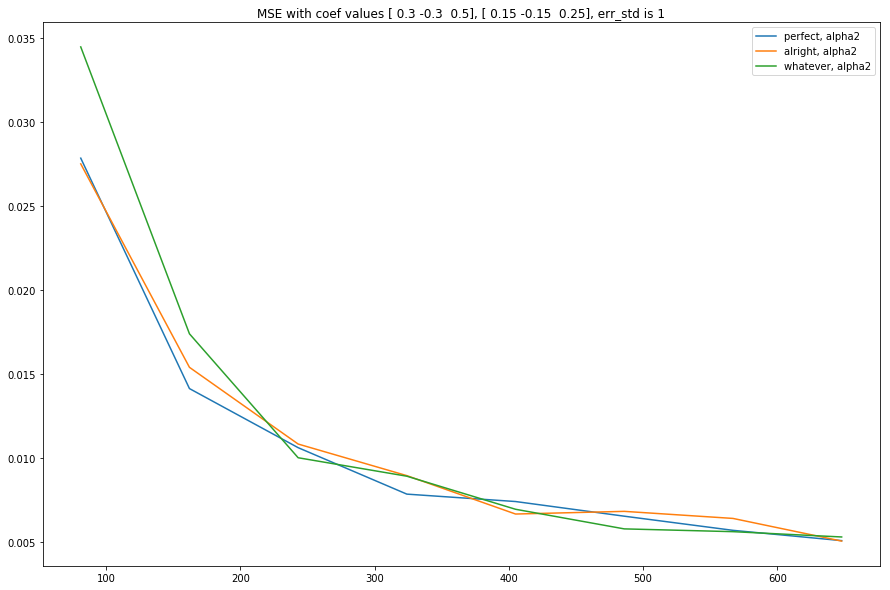

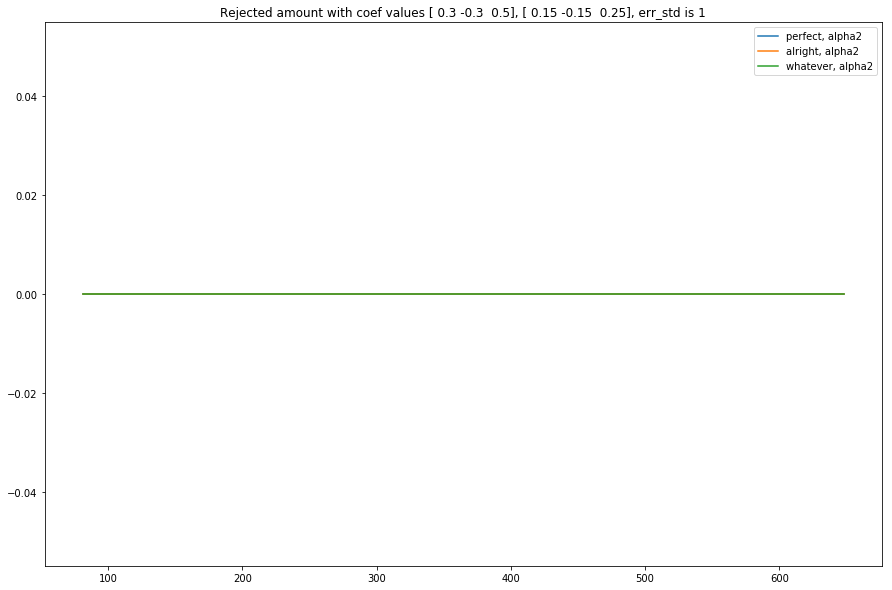

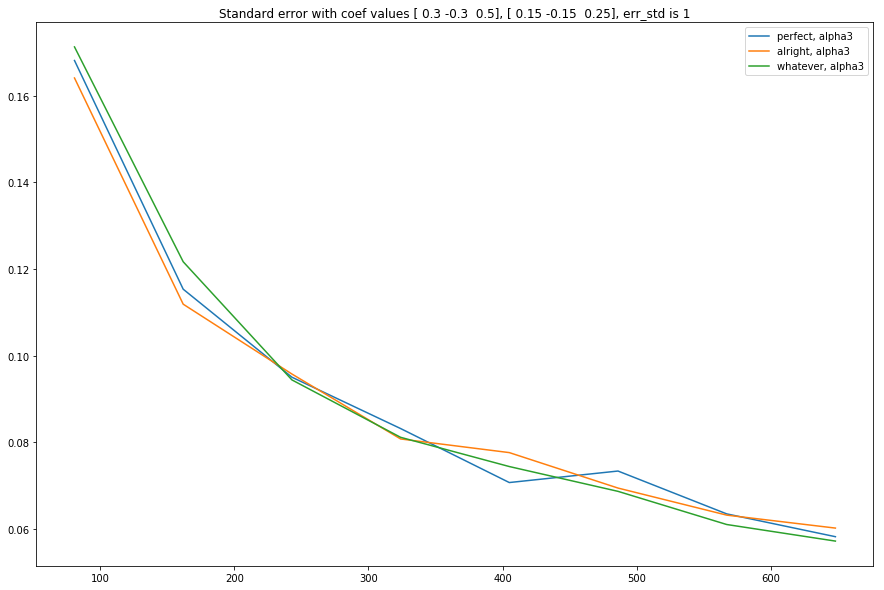

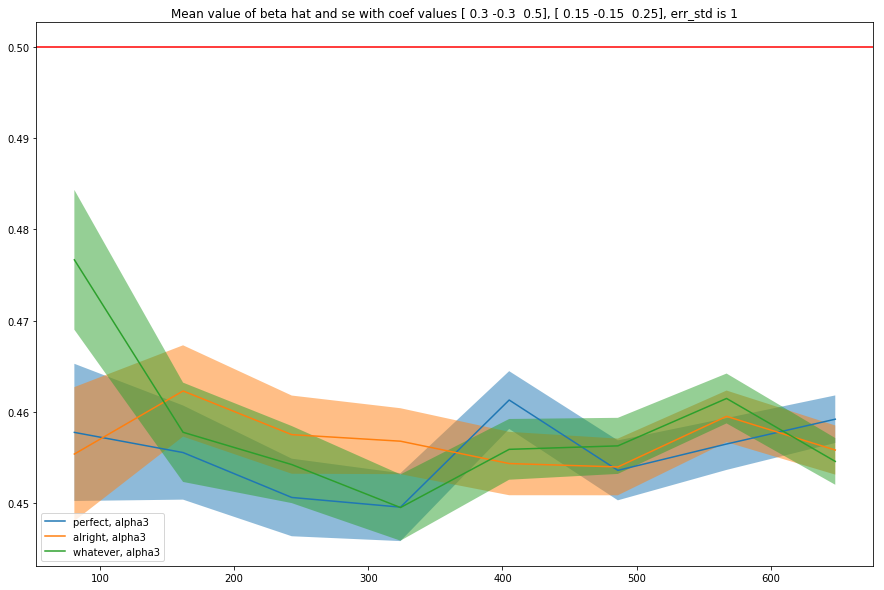

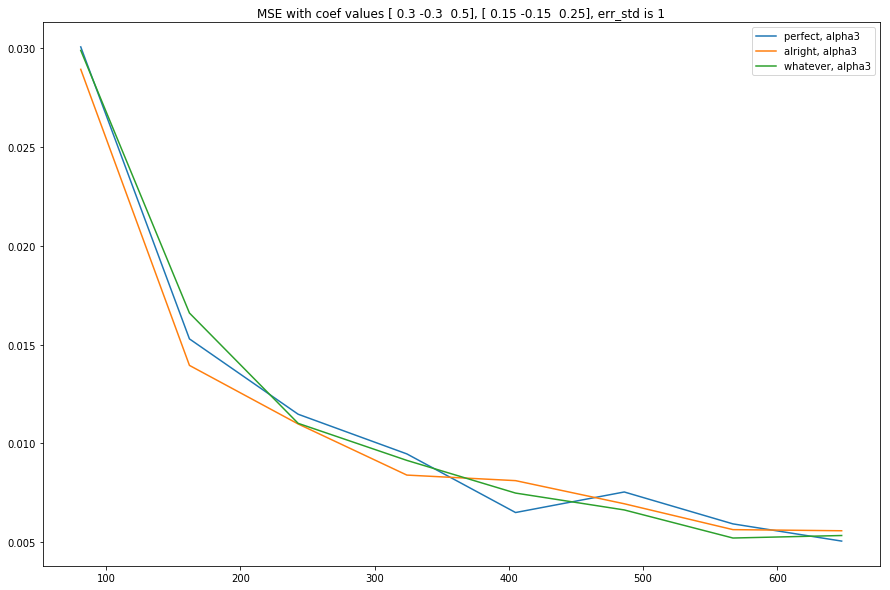

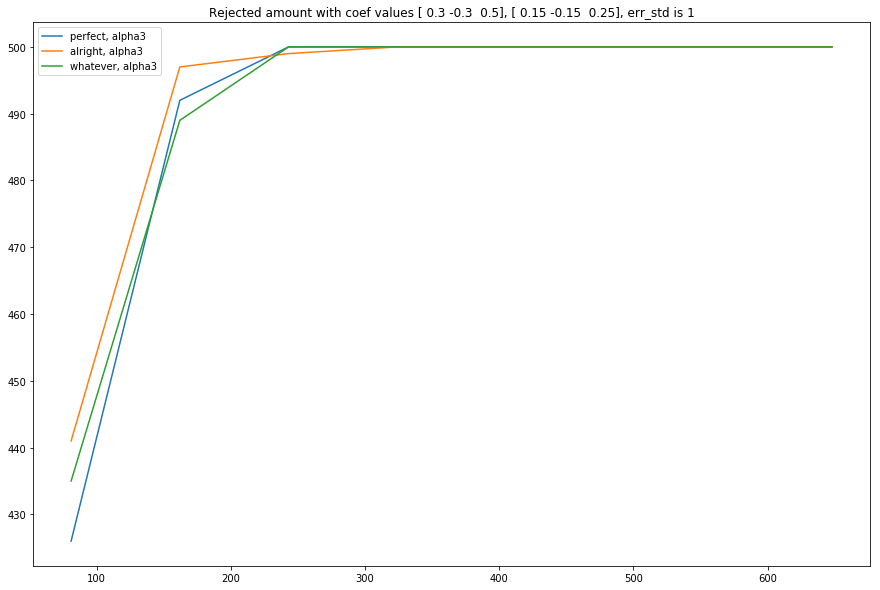

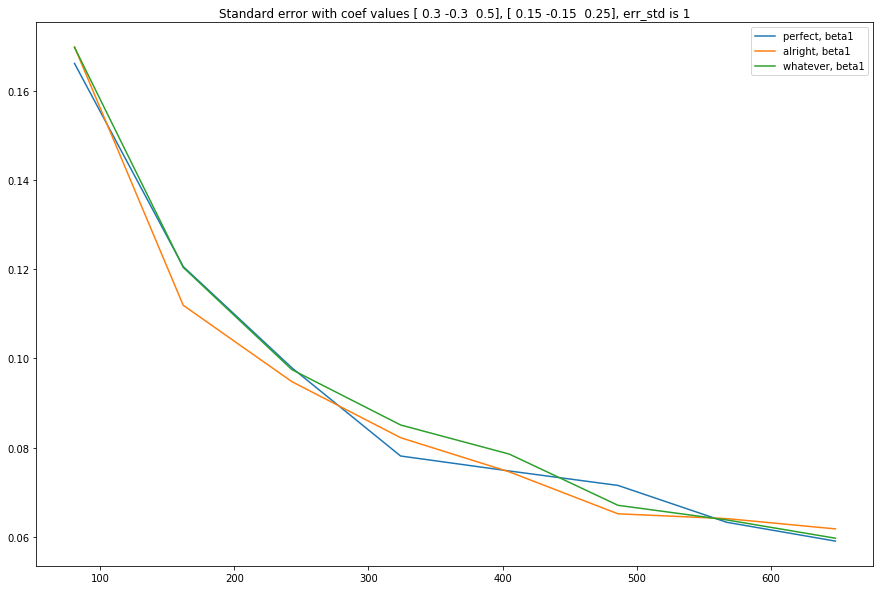

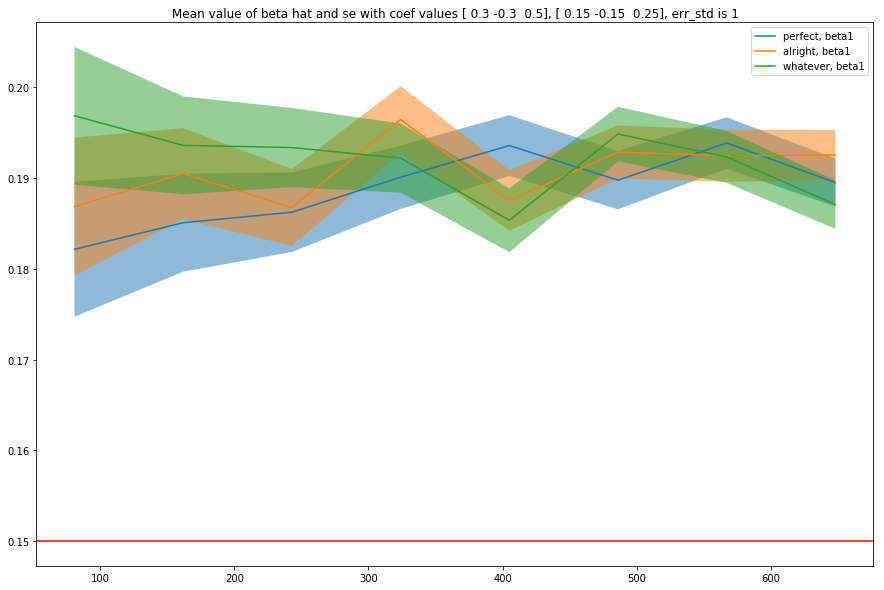

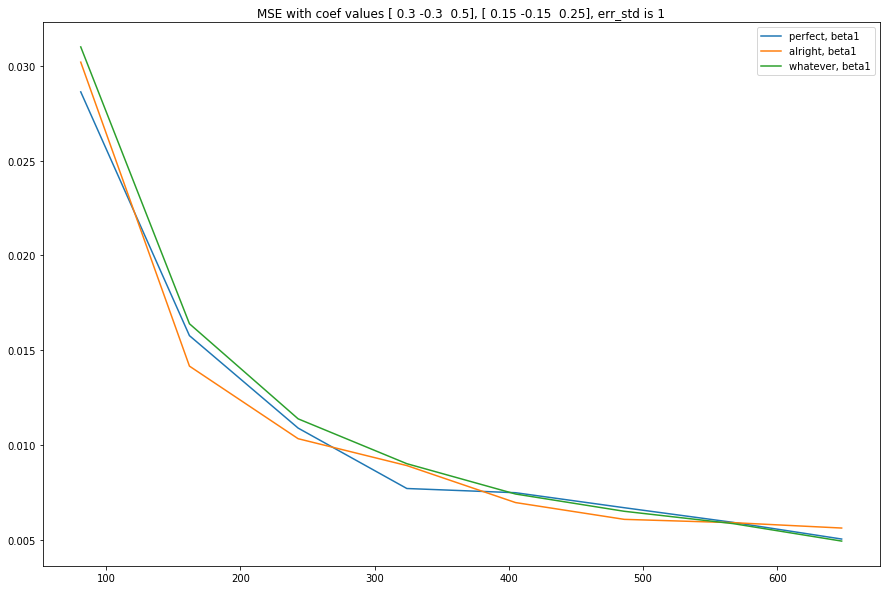

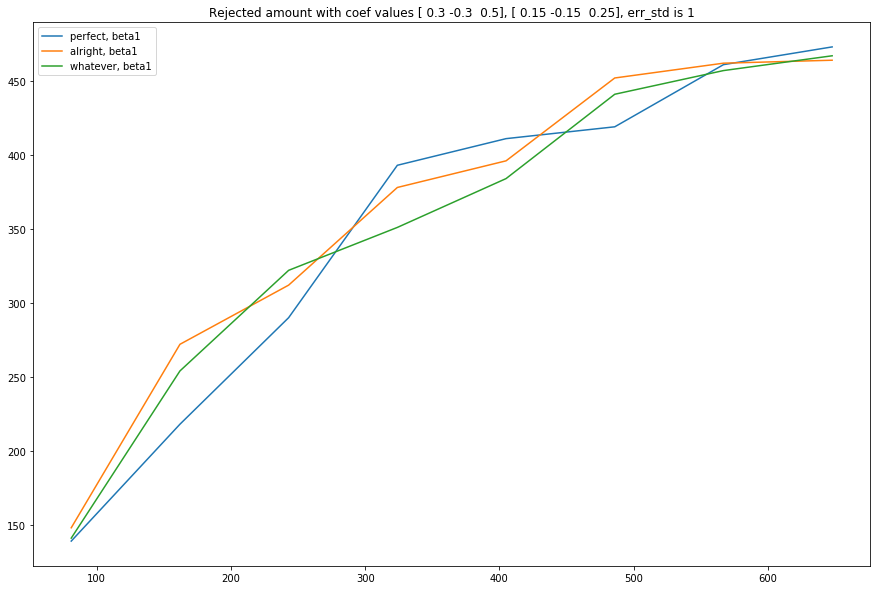

In [ ]:
alpha_list = [np.array([0.3, -0.3, 0.5]), np.array([0.5, -0.5, 0.7]), np.array([0.7, -0.7, 0.9]), 
              np.array([0.9, -0.9, 1.5]), np.array([1.5, -1.2, 2])]
beta_list = [alpha_list[i] / 2 for i in range(len(alpha_list))]

for i in range(len(alpha_list)):
    for j in range(1,6):
        draw_plot_trt3(alpha_list[i],beta_list[i], j)

In [80]:
# For the second order case, i.e., consider column x-2 and possibly other column
# And for the first two elements of the sequence, treat with caution 

def new_design_matrix_trt3_2(full_sequence, product = False):
    """
    Return a matrix containing treatment like:
        today       yesterday    the day before yesterday
    t   A  B  C    A  B  C       A  B  C
    0   1  0  0    0  1  0       0  0  1
    1   0  1  0    1  0  0       0  1  0
    2   0  0  1    0  1  0       1  0  0
    .....
    .....
    
    Here we only consider three treatment types (A,B,C) and hence when t1 is using A, then the A column of t1
    will be 1 and B, C columns of t1 should all be 0.
    
    Still, as before, we don't consider the first and second day(they only show up in the yesterday and the day
            before yeasterday part, not today part).
    
    !!!! Also, product part to be developed.
    
    Parameter:
    ------------------
    full_seuqnce: the sequence to consider
    """
    seq_len = len(full_sequence)
    column_len = 9
    if product == True:
        column_len = 10
    dm = np.zeros([seq_len - 2, column_len])
    for i in range(seq_len):
        if i == 0: # The first element in the sequence (not show in first and second column)
            if full_sequence[i] == "A":
                dm[i, 6] = 1
            elif full_sequence[i] == "B":
                dm[i, 7] = 1
            else:
                dm[i, 8] = 1
        elif i == 1: # The second element in the sequence (not show in first column)
            if full_sequence[i] == "A":
                dm[i - 1, 3] = 1
                dm[i, 6] = 1
            elif full_sequence[i] == "B":
                dm[i - 1, 4] = 1
                dm[i, 7] = 1
            else:
                dm[i - 1, 5] = 1
                dm[i, 8] = 1
        elif i == seq_len - 2: # The second last element in the sequence (not show in third column)
            if full_sequence[i] == "A":
                dm[i - 2, 0] = 1
                dm[i - 1, 3] = 1
            elif full_sequence[i] == "B":
                dm[i - 2, 1] = 1
                dm[i - 1, 4] = 1
            else:
                dm[i - 2, 2] = 1
                dm[i - 1, 5] = 1
        elif i == seq_len - 1: # The last element in the sequence (not show in second and third column)
            if full_sequence[i] == "A":
                dm[i - 2, 0] = 1
            elif full_sequence[i] == "B":
                dm[i - 2, 1] = 1
            else:
                dm[i - 2, 2] = 1
        else: # All the middle elements (show in all column)
            if full_sequence[i] == "A":
                dm[i - 2, 0] = 1
                dm[i - 1, 3] = 1
                dm[i, 6] = 1
            elif full_sequence[i] == "B":
                dm[i - 2, 1] = 1
                dm[i - 1, 4] = 1
                dm[i, 7] = 1
            else:
                dm[i - 2, 2] = 1
                dm[i - 1, 5] = 1
                dm[i, 8] = 1
                
#         if product == True: # if requires product, create a fourth column by multiplying the first two column
#             dm[:, 3] = dm[:, 0] * dm[:, 1]
    
    return dm

In [ ]:
# A demo

In [81]:
def new_get_y_trt3_2(alpha, beta, gamma, design_matrix, err_std = 1):
    """
    Here alpha and beta are both 3-element vector, where alpha[1] represents A's treatment effect for today,
        and alpha[2], alpha[3] represents B and C respectively. Beta and gamma are similar but represent yesterday
        and the day before yesterday.
        
    y_t = alpha * design_m[:,0:2] + beta * design_m[:,3:5] + gamma * design_m[:,6:8]
    
    
    Parameters:
    -------------------
    alpha: parameter corresponding with current item
    beta: parameter corresponding with immediately previous item
    gamma: parameter corresponding with the second previous item
    design_matrix: the matrix calculated by the design matrix function
    err_std: error term's standard deviation, default is 1. (error term is draw from a normal distribution
             with mean 0 and std the given value or 1 by default)
    """
    
    m, n = design_matrix.shape
    y = np.matmul(design_matrix[:, 0:3], alpha.reshape(3,1)) + np.matmul(design_matrix[:, 3:], beta.reshape(3,1)) \
        + np.matmul(design_matrix[:, 6:8], gamma.reshape(3,1)) + np.random.normal(0, err_std, m).reshape(m, 1)
    
    
    return y 

In [85]:
# Second order case

def experiment_trt3_2(alpha, beta, gamma, quality, product = False, err_std = 1, sample_size = 500):
    """
    Run an experiment and return dictionary containing beta values
    
    Parameters:
    -------------------
    quality: state what quality do you want for the experiment, "perfect" means all sample latin square need to
             pass the test, "alright" means the latin square samples that don't pass the test, "whatever" means
             random sequence
    sample_size: how many samples to draw, default is 1000
    other parameters similar as in other functions
    """
    
    seq_size_list = seq_size_list = [81 + 81 * i for i in range(8)]
    
    alpha1_dict = {}
    alpha2_dict = {}
    alpha3_dict = {}
    beta1_dict = {}
    beta2_dict = {}
    beta3_dict = {}
    gamma1_dict = {}
    gamma2_dict = {}
    gamma3_dict = {}
    
    # Draw sample and calculate standard error of beta
    for seq_size in seq_size_list:
        count = 0
        alpha1_dict[seq_size] = []
        alpha2_dict[seq_size] = []
        alpha3_dict[seq_size] = []
        beta1_dict[seq_size] = []
        beta2_dict[seq_size] = []
        beta3_dict[seq_size] = []
        gamma1_dict[seq_size] = []
        gamma2_dict[seq_size] = []
        gamma3_dict[seq_size] = [] 
        
        while count < sample_size:
            var_dict, seq_dict = initiation(3, "second")
            if "whatever" not in quality:
                r1, r2 = get_sequence(seq_dict, var_dict, seq_size)
                if r2 == True and "perfect" in quality:
                    dm = new_design_matrix_trt3_2(r1, product)
                    y = new_get_y_trt3_2(alpha, beta, gamma, dm, err_std = err_std)
                    coefs,a,b,c = np.linalg.lstsq(dm, y, rcond = None) # a,b,c is other values the function returns
                                                                        # not important, so we use a,b,c
                    alpha1_dict[seq_size].append(coefs[0])
                    alpha2_dict[seq_size].append(coefs[1])
                    alpha3_dict[seq_size].append(coefs[2])
                    beta1_dict[seq_size].append(coefs[3])
                    beta2_dict[seq_size].append(coefs[4])
                    beta3_dict[seq_size].append(coefs[5])
                    gamma1_dict[seq_size].append(coefs[6])
                    gamma2_dict[seq_size].append(coefs[7])
                    gamma3_dict[seq_size].append(coefs[8])
                    count += 1
                elif "alright" in quality:
                    dm = new_design_matrix_trt3_2(r1, product)
                    y = new_get_y_trt3_2(alpha, beta, gamma, dm, err_std = err_std)
                    coefs,a,b,c = np.linalg.lstsq(dm, y, rcond = None) # a,b,c is other values the function returns
                                                                        # not important, so we use a,b,c
                    alpha1_dict[seq_size].append(coefs[0])
                    alpha2_dict[seq_size].append(coefs[1])
                    alpha3_dict[seq_size].append(coefs[2])
                    beta1_dict[seq_size].append(coefs[3])
                    beta2_dict[seq_size].append(coefs[4])
                    beta3_dict[seq_size].append(coefs[5])
                    gamma1_dict[seq_size].append(coefs[6])
                    gamma2_dict[seq_size].append(coefs[7])
                    gamma3_dict[seq_size].append(coefs[8])
                    count += 1
            else: # All random case
                sequence = random_sequence(2, seq_size)
                dm = new_design_matrix_trt3_2(sequence, product)
                y = new_get_y_trt3_2(alpha, beta, gamma, dm, err_std = err_std)
                coefs,a,b,c = np.linalg.lstsq(dm, y, rcond = None) # a,b,c is other values the function returns
                                                                        # not important, so we use a,b,c
                alpha1_dict[seq_size].append(coefs[0])
                alpha2_dict[seq_size].append(coefs[1])
                alpha3_dict[seq_size].append(coefs[2])
                beta1_dict[seq_size].append(coefs[3])
                beta2_dict[seq_size].append(coefs[4])
                beta3_dict[seq_size].append(coefs[5])
                gamma1_dict[seq_size].append(coefs[6])
                gamma2_dict[seq_size].append(coefs[7])
                gamma3_dict[seq_size].append(coefs[8])
                count += 1
            
    return alpha1_dict, alpha2_dict, alpha3_dict, beta1_dict, beta2_dict, beta3_dict, gamma1_dict, gamma2_dict, gamma3_dict 

In [86]:
def draw_plot_2(alpha,beta, gamma, draw, product, err_std = 1, sample_size = 500):
    """
    Draw 3 plots:
    1. for standard error of betas
    2. mean value of beta hat and std
    3. MSE of beta hat
    
    Parameters:
    -------------------
    draw: which beta to draw, give 1 or 2 or 3 or 4, (if 4, product must be true)
    parameters similar as the above function
    !!!! Product to be developed
    
    """
    name_dict = {1:"alpha1", 2:"alpha2", 3: "alpha3", 4: "beta1", 5: "beta2", 6: "beta3", 7: "gamma1", 
                8: "gamma2", 9: "gamma3"}
    fig, ax1 = plt.subplots(figsize = (15,10))
    fig, ax2 = plt.subplots(figsize = (15,10))
    fig, ax3 = plt.subplots(figsize = (15,10))
    fig, ax4 = plt.subplots(figsize = (15,10))
    quality_list = ["perfect", "alright", "whatever"]
    for qu in quality_list:
        mean_list = []
        se_list = []
        mse_list = []
        reject_dict = {}
        result = experiment_trt3_2(alpha, beta, gamma, qu, product = product, 
                                    err_std = err_std, sample_size = sample_size)
        coef_to_draw_dict = result[draw - 1]
        
        for key in coef_to_draw_dict:
            reject_dict[key] = 0
            if product == True:
                df_num = key - 10
            else:
                df_num = key - 9
                
            for i in range(sample_size):
                if 1 - stats.t.cdf(coef_to_draw_dict[key][i] / np.std(coef_to_draw_dict[key]), df = df_num) < 0.05:
                    reject_dict[key] += 1

            mean_list.append(np.mean(coef_to_draw_dict[key]))
            se_list.append(np.std(coef_to_draw_dict[key]))# / np.sqrt(sample_size))
            if draw <= 3: 
                mse_list.append(MSE(np.array(coef_to_draw_dict[key]), alpha[draw - 1]))
            elif draw <= 6:
                mse_list.append(MSE(np.array(coef_to_draw_dict[key]), beta[draw - 4]))
            else:
                mse_list.append(MSE(np.array(coef_to_draw_dict[key]), gamma[draw - 7]))
        
        mean_std = np.array(se_list) / np.sqrt(sample_size)
        
        # Actual plotting
        # First plot
        ax1.plot(coef_to_draw_dict.keys(), se_list, label = "{}, {}".format(qu, name_dict[draw]))
        
        # Second plot
        ax2.plot(coef_to_draw_dict.keys(), mean_list, label = "{}, {}".format(qu, name_dict[draw]))
        ax2.fill_between(coef_to_draw_dict.keys(), np.array(mean_list) - mean_std, 
                        np.array(mean_list) + mean_std, alpha = 0.5)
        
        # Third plot
        ax3.plot(coef_to_draw_dict.keys(), mse_list, label = "{}, {}".format(qu, name_dict[draw]))
        
        # Fourth plot
        ax4.plot(coef_to_draw_dict.keys(), reject_dict.values(), label = "{}, {}".format(qu, name_dict[draw]))
        
    ax1.set_title("Standard error with coef values {}, {}, {}, err_std is {}".format(alpha,beta,gamma,err_std))
    ax1.legend()
    
    ax2.set_title("Mean value of beta hat and se with coef values {}, {},{}, err_std is {}".format(alpha,beta,
                                                                                                   gamma,err_std))
    ax2.axhline(y = name_dict[draw], color='r', linestyle='-')
    ax2.legend()
    
    ax3.set_title("MSE with beta values {}, {}, {}, err_std is {}".format(alpha,beta,gamma,err_std))
    ax3.legend()
    
    ax4.set_title("Rejected amount with beta values {}, {}, {}, err_std is {}".format(alpha,beta,gamma,err_std))
    ax4.legend()
    
    plt.show()
    
    return None

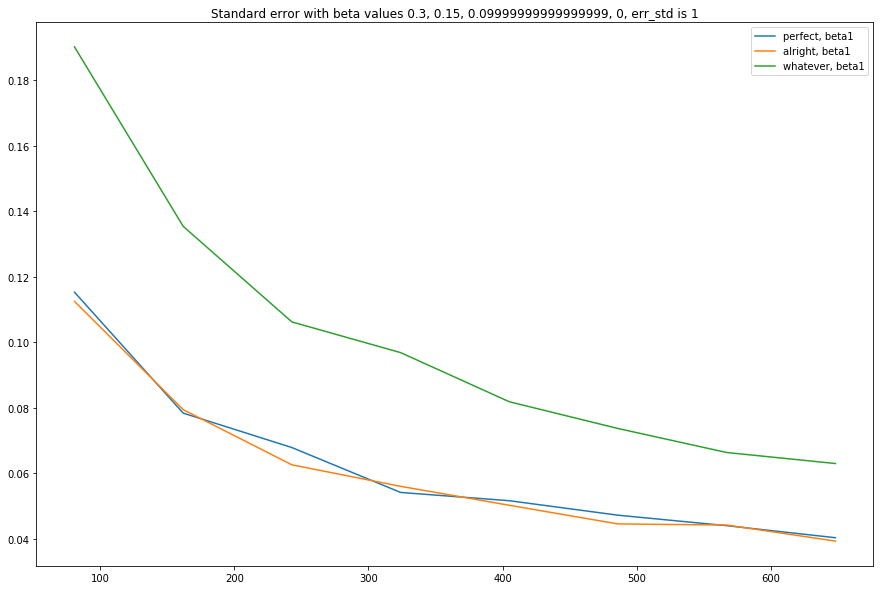

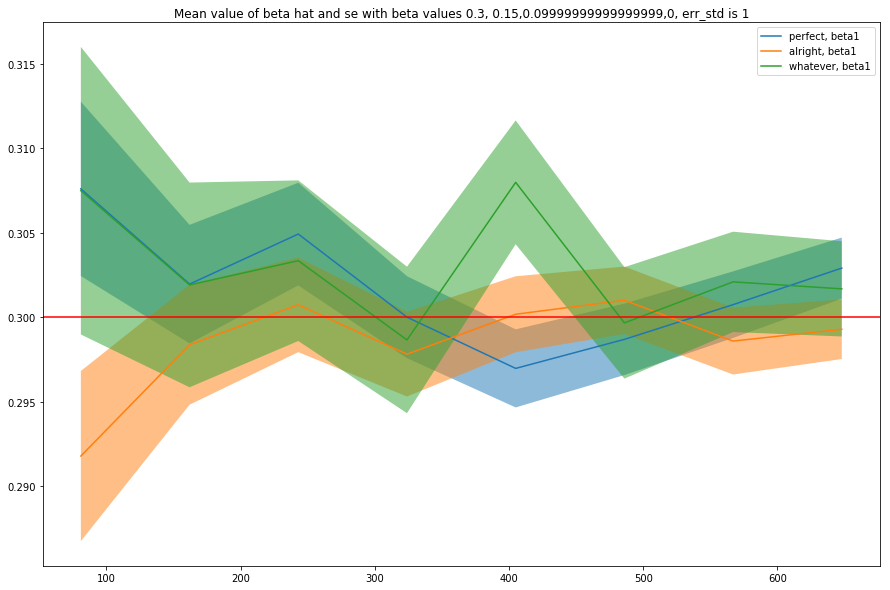

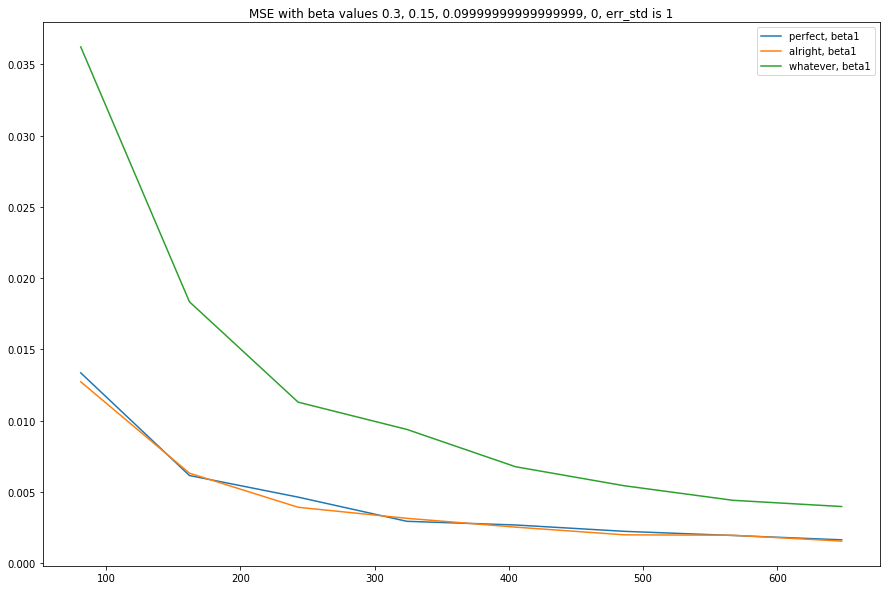

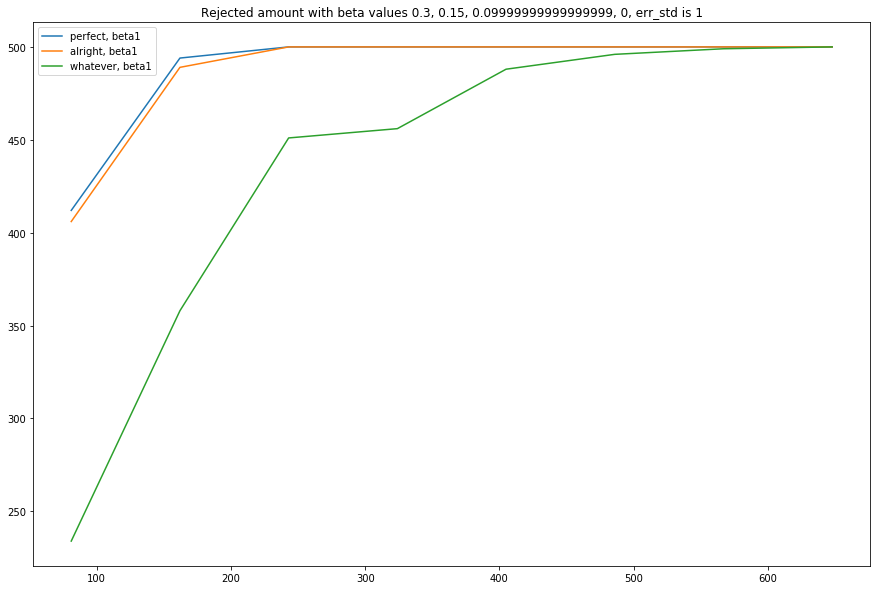

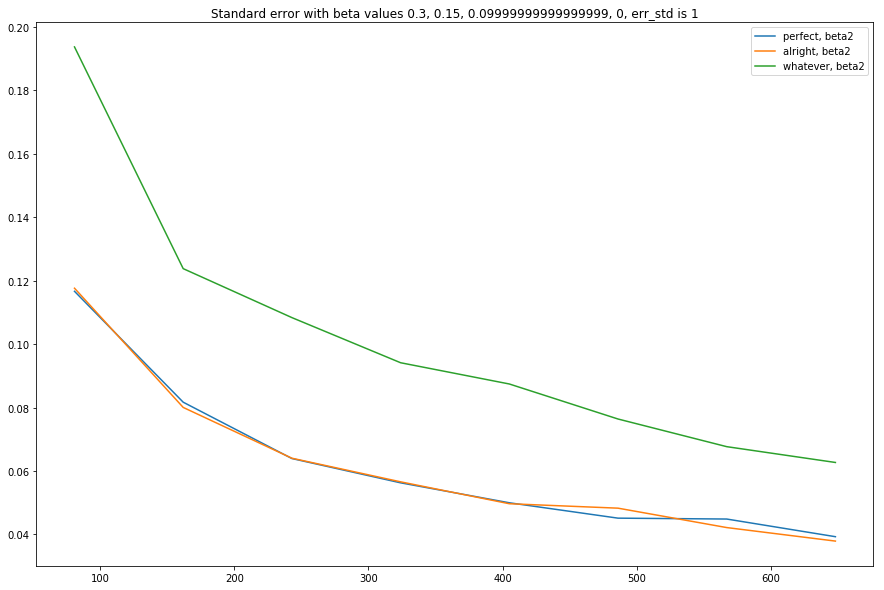

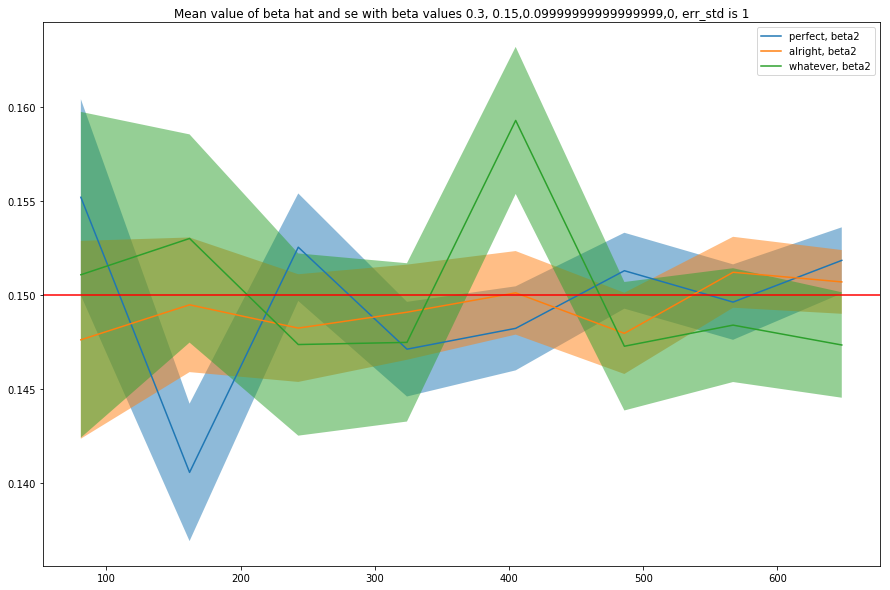

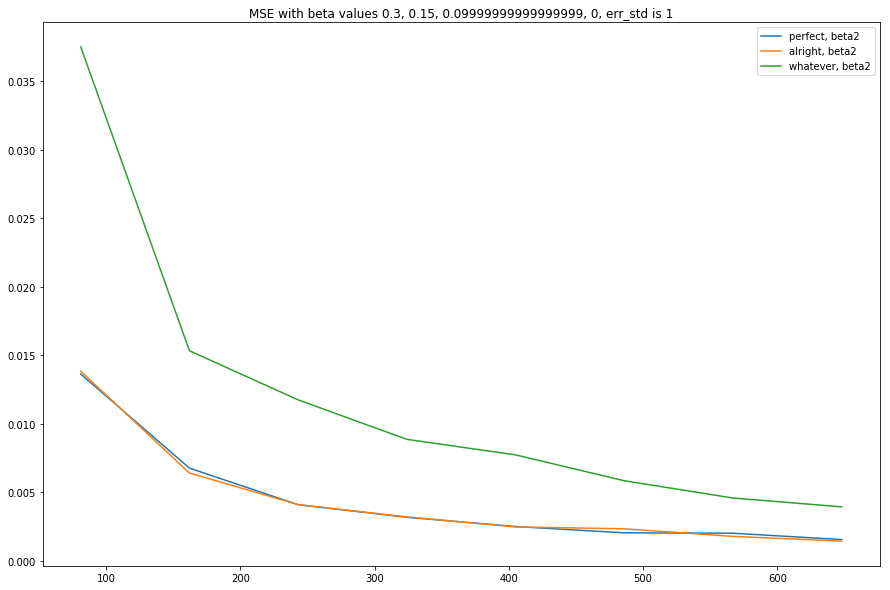

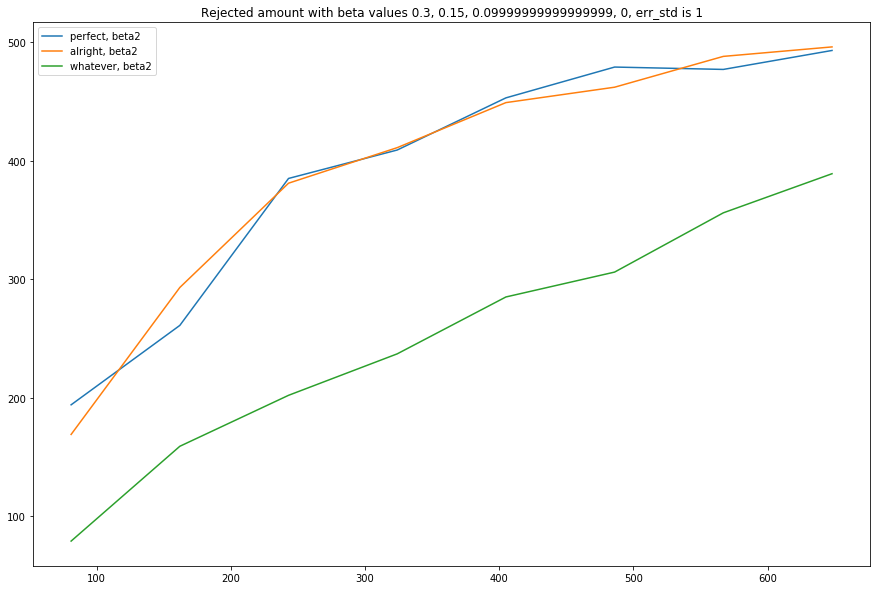

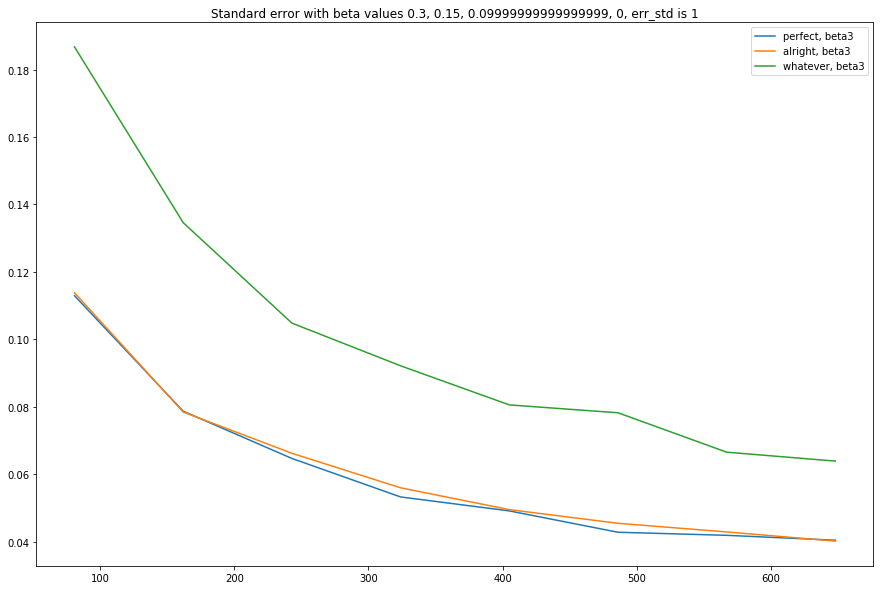

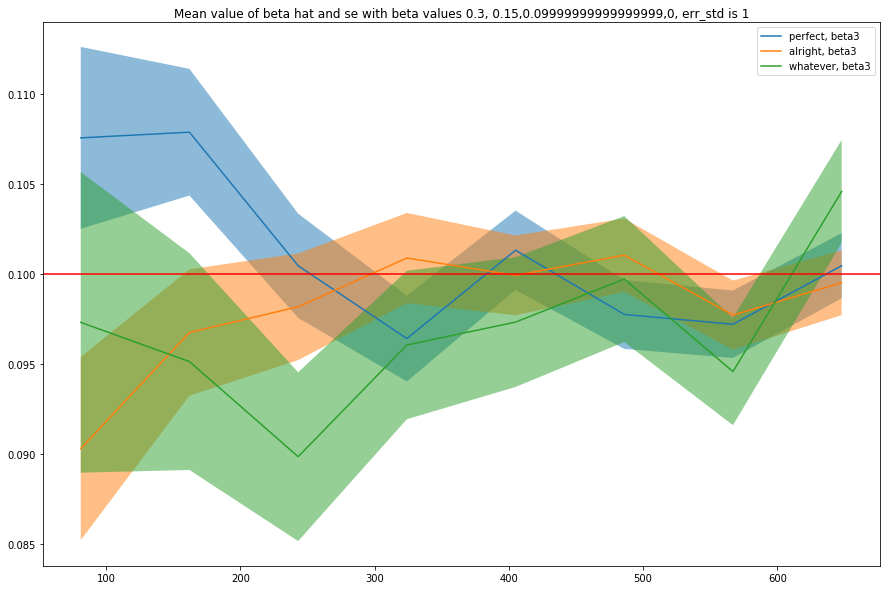

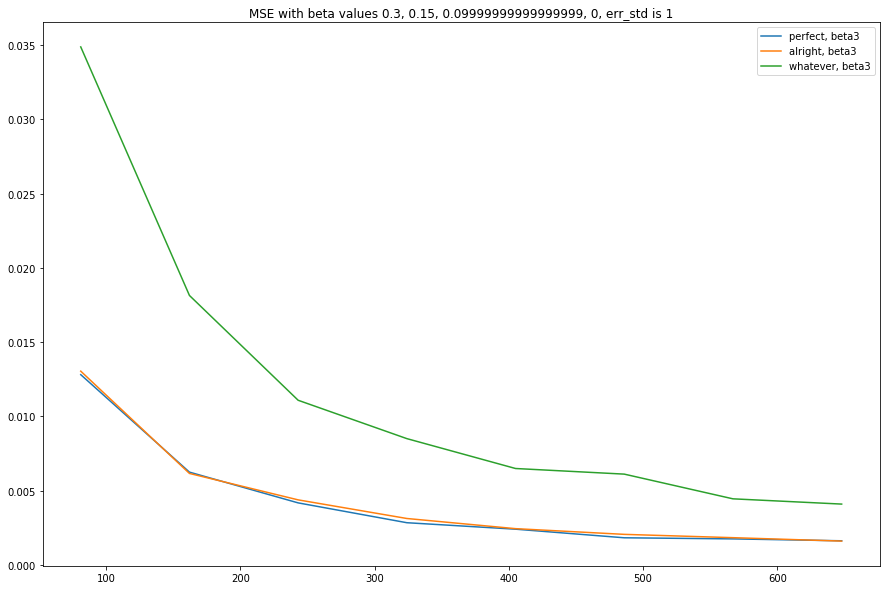

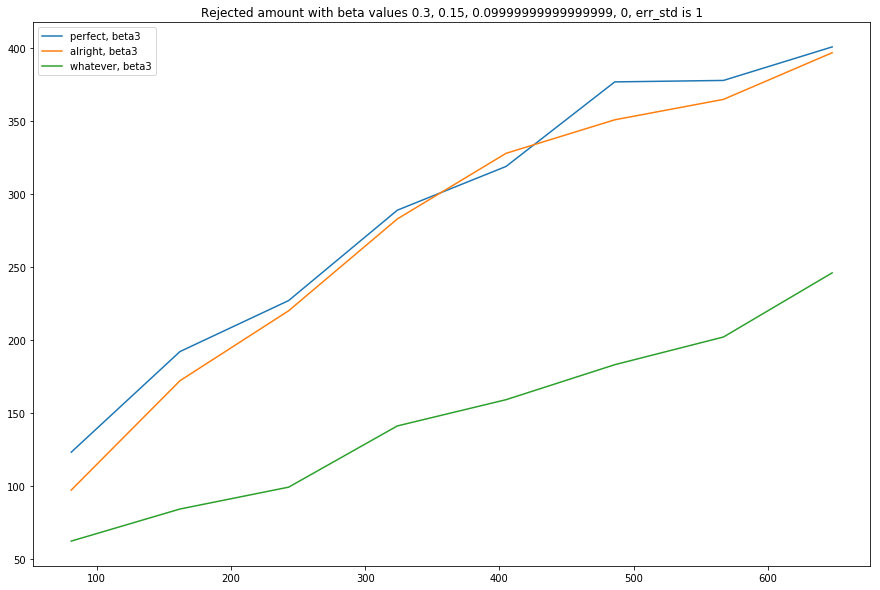

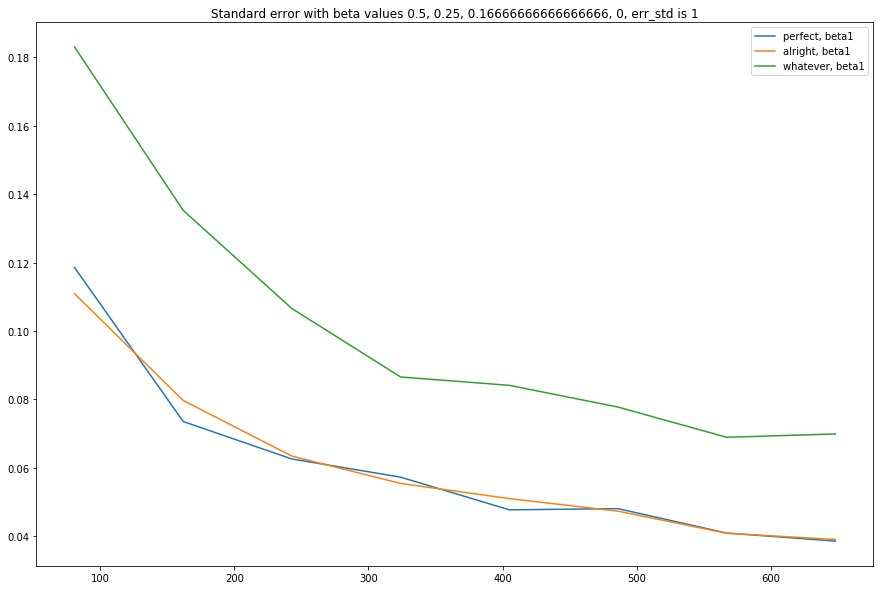

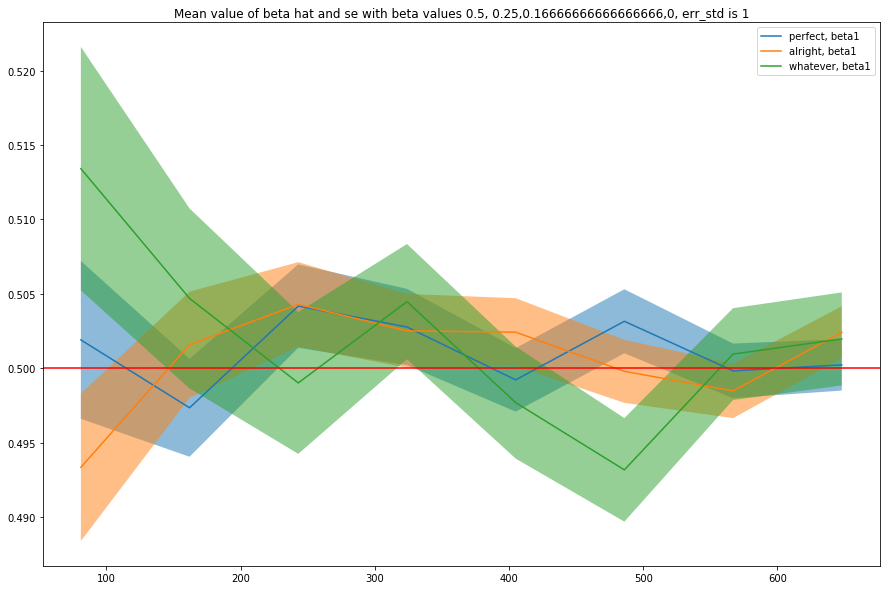

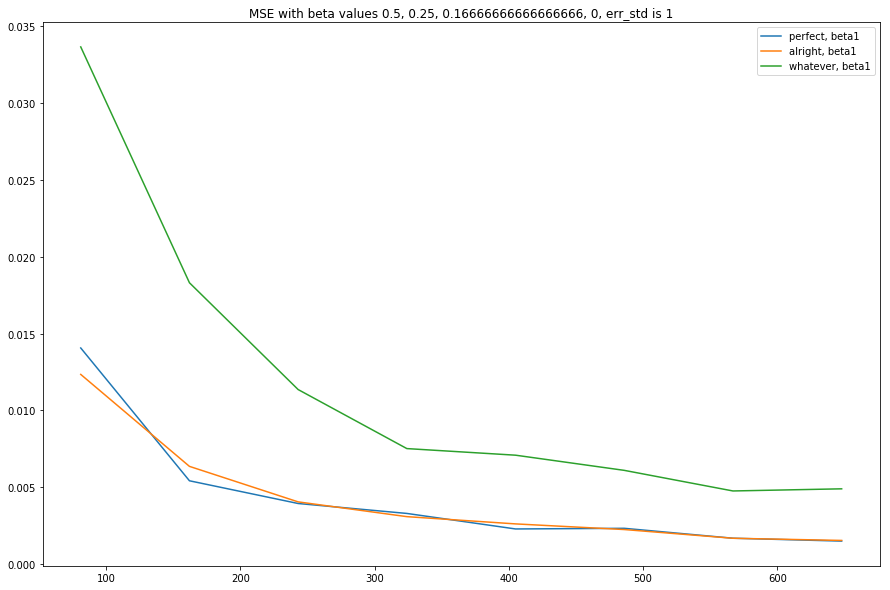

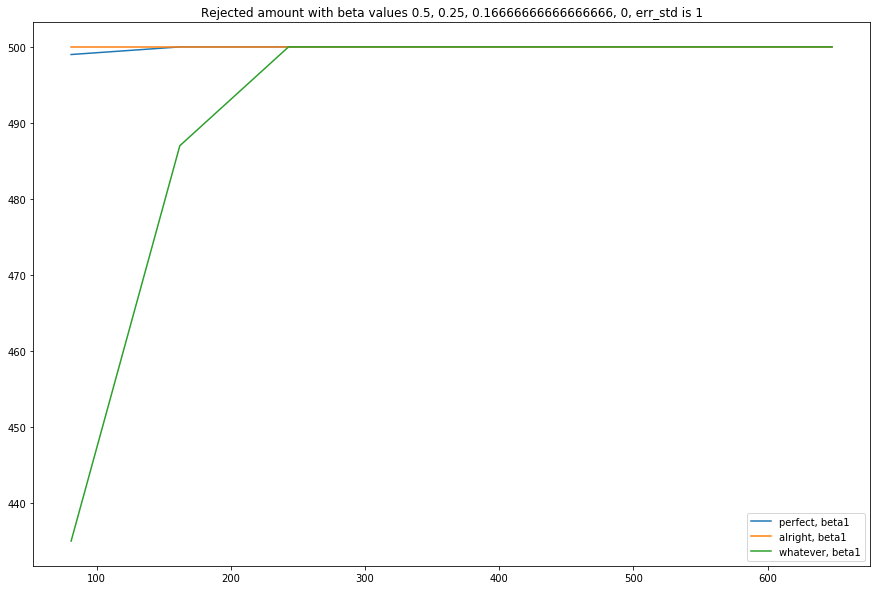

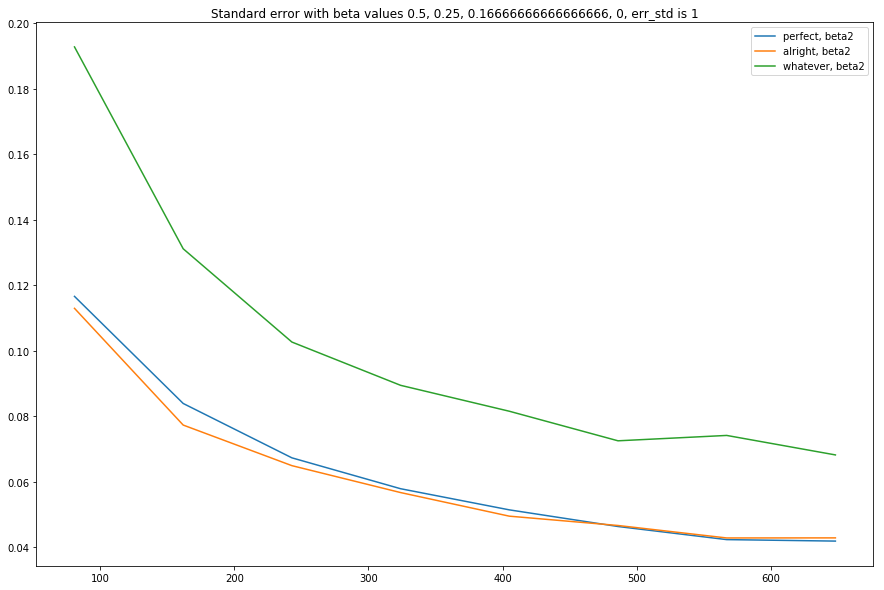

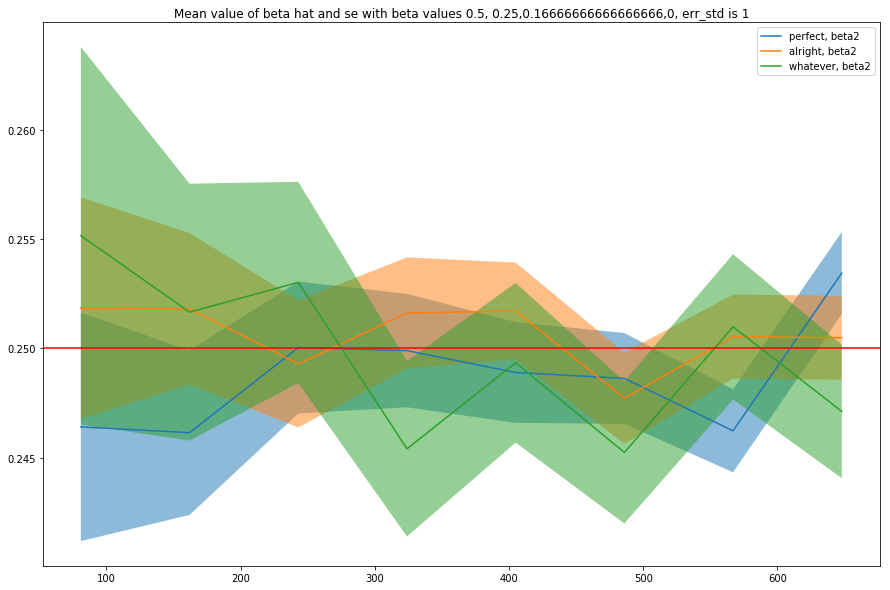

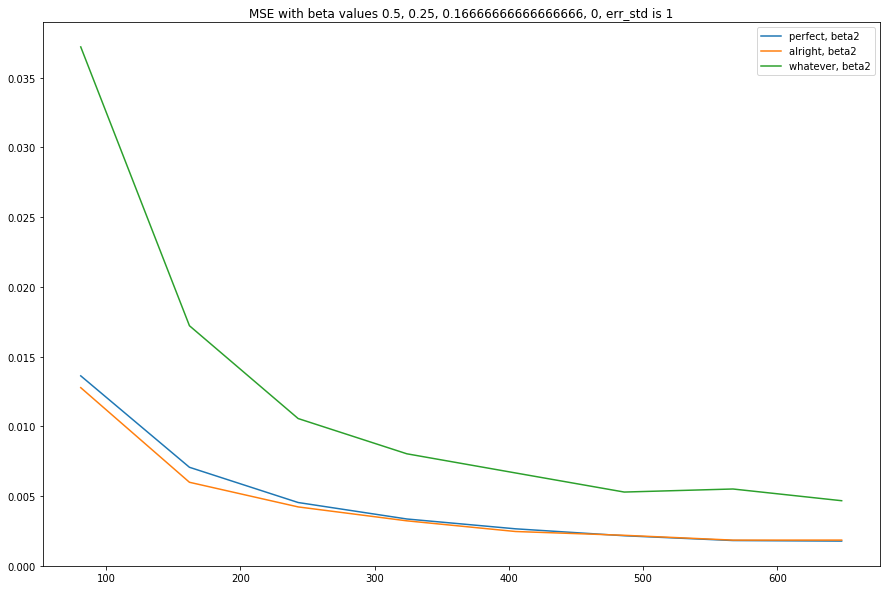

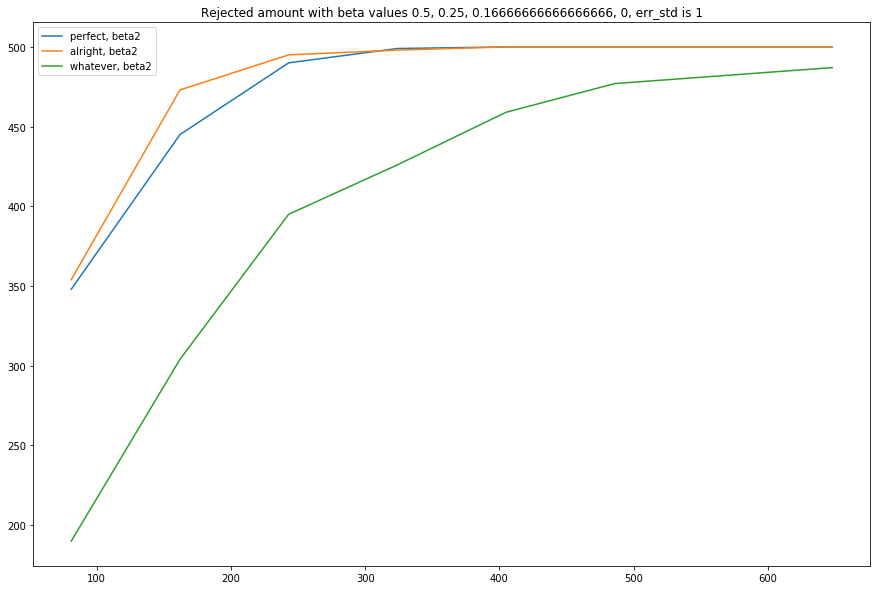

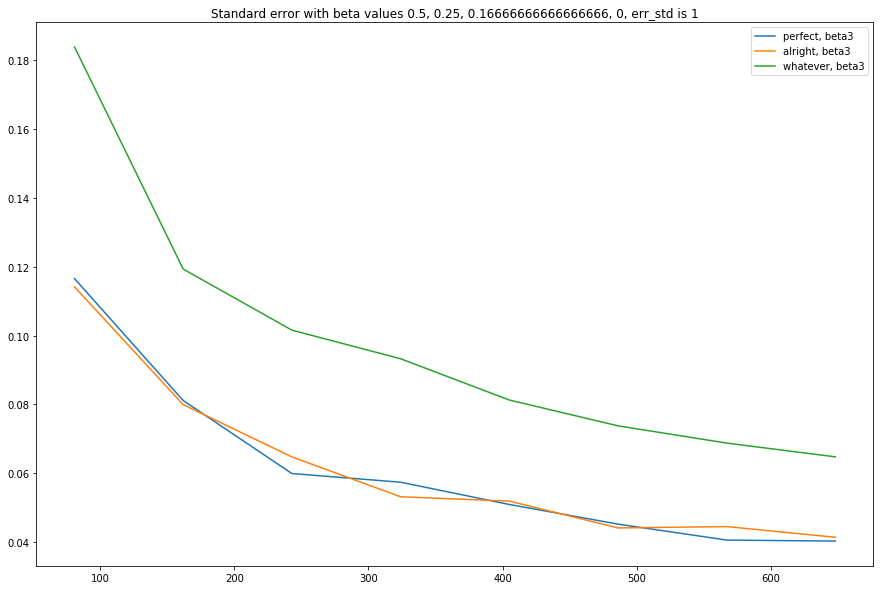

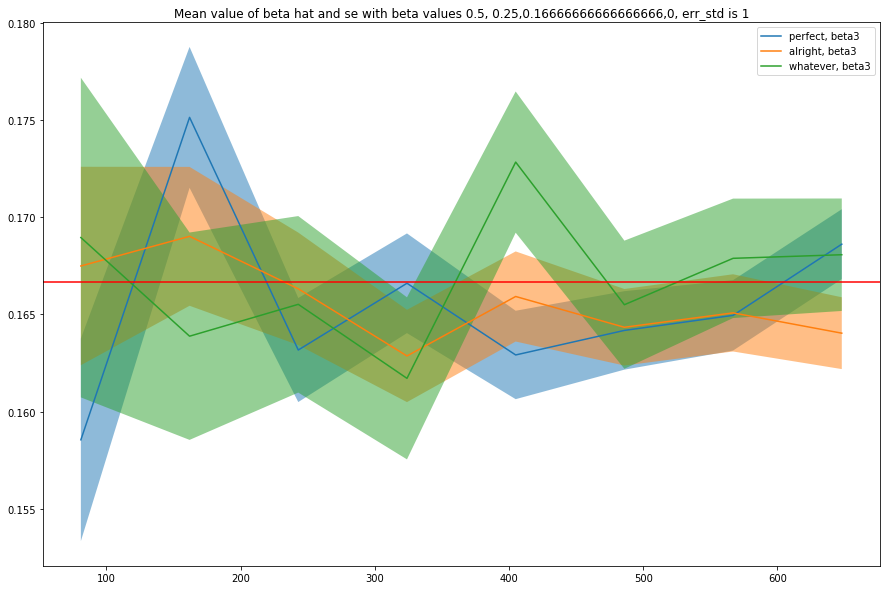

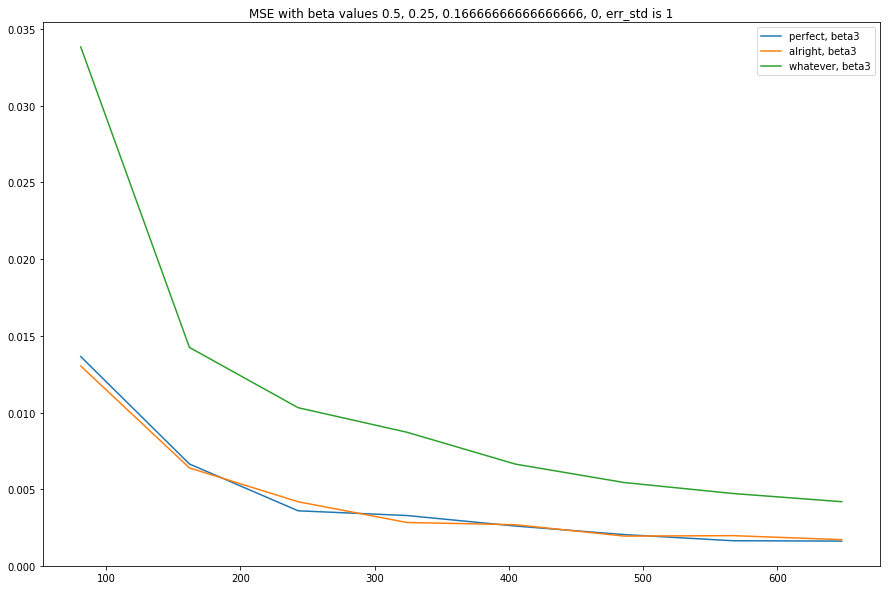

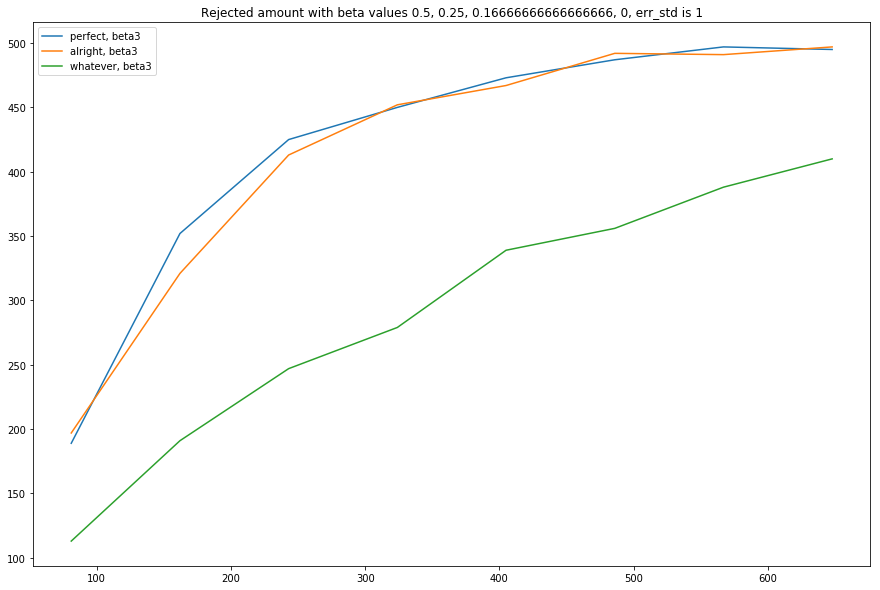

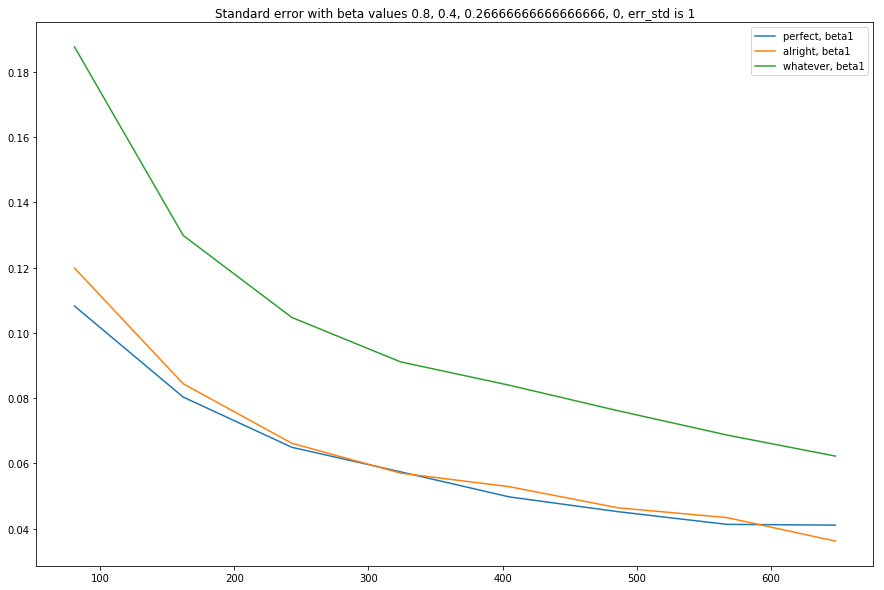

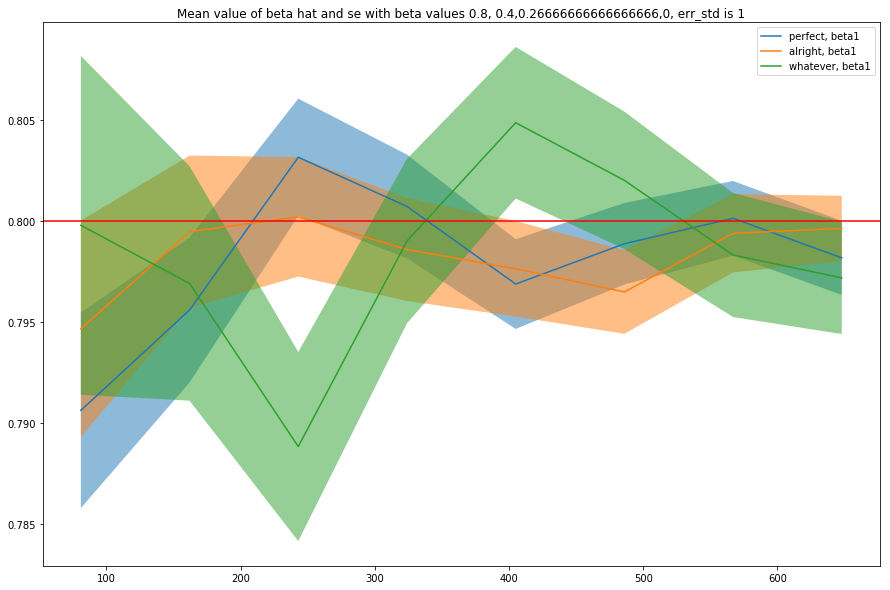

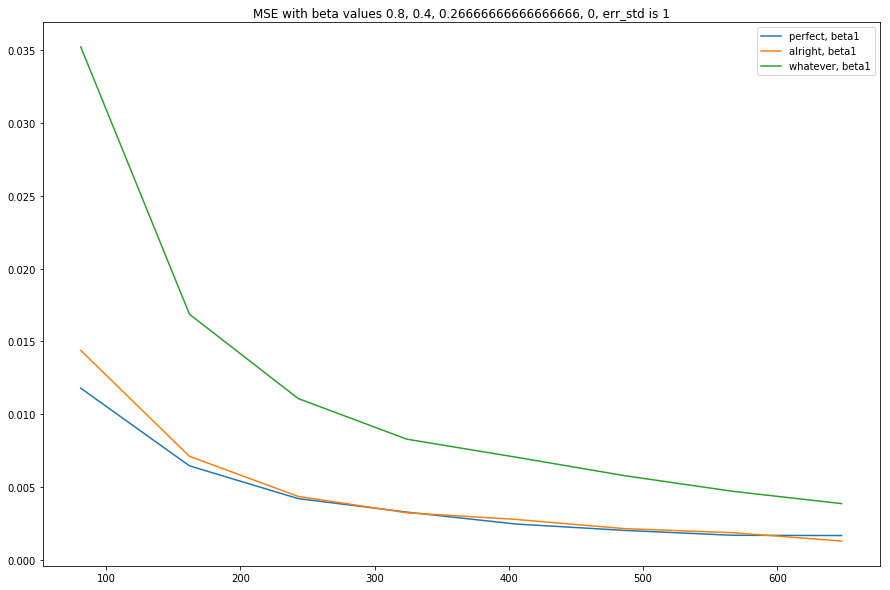

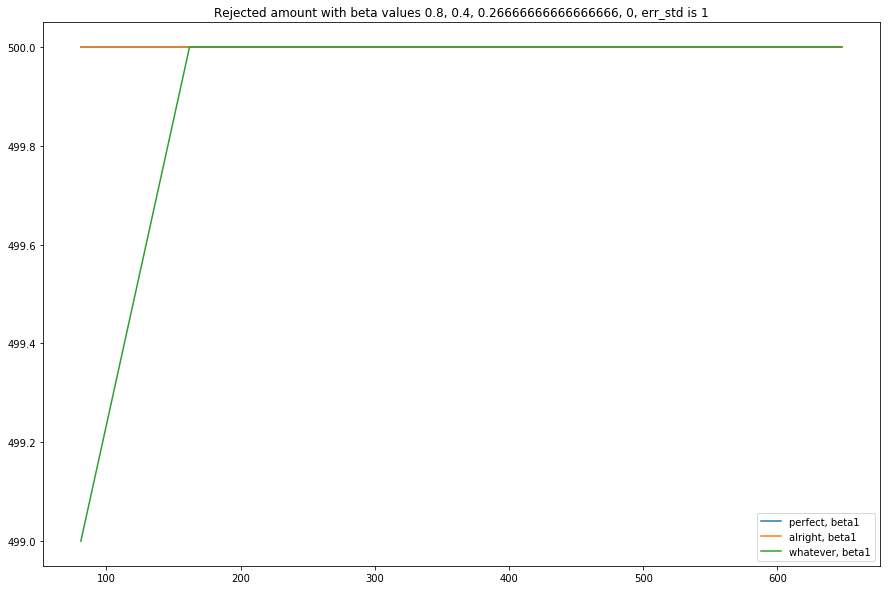

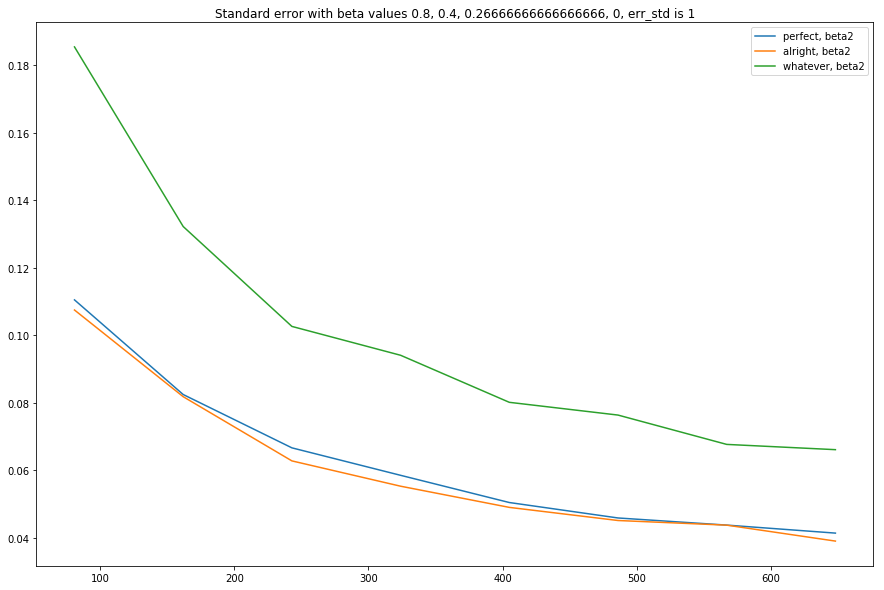

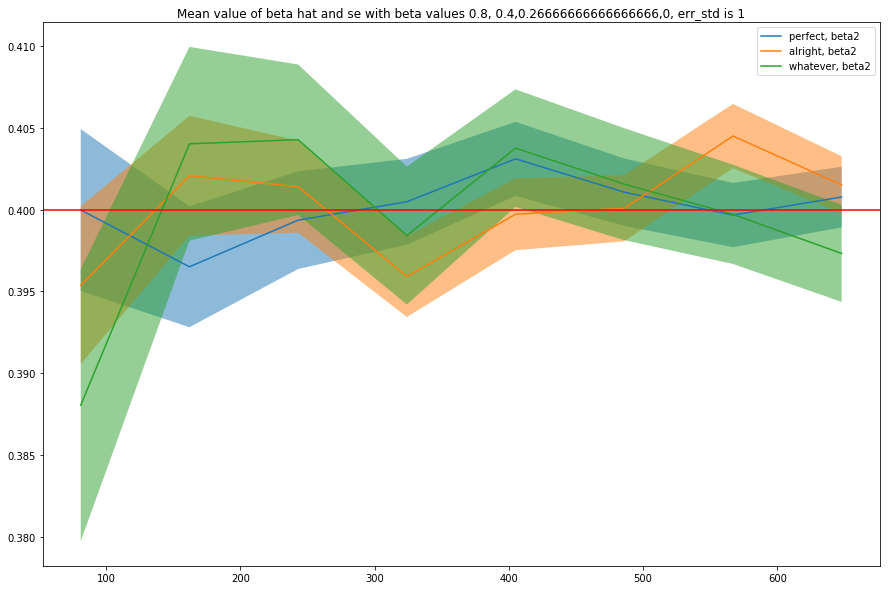

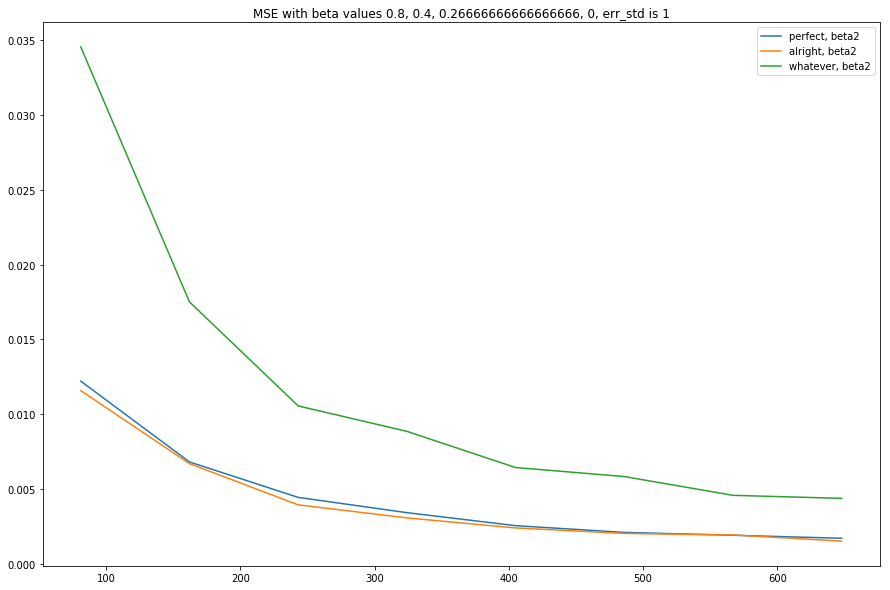

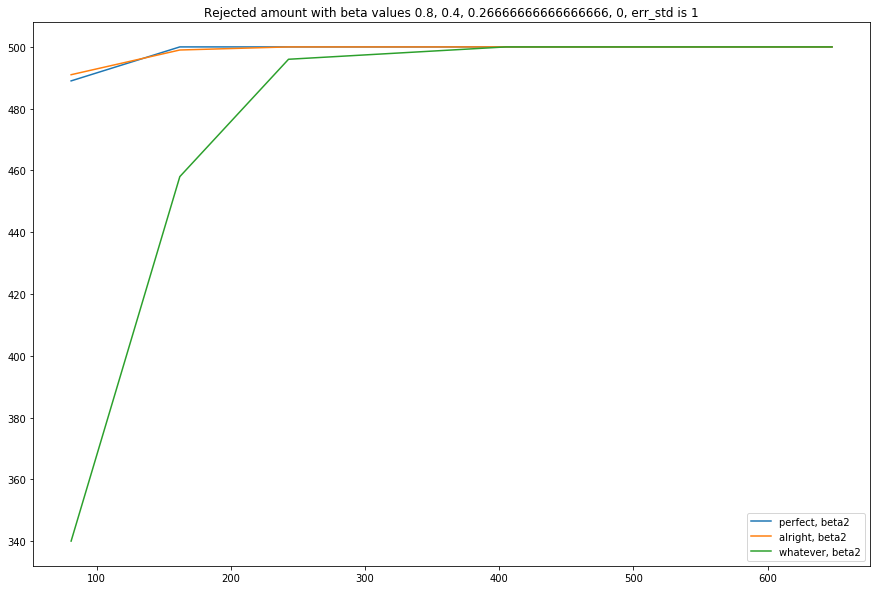

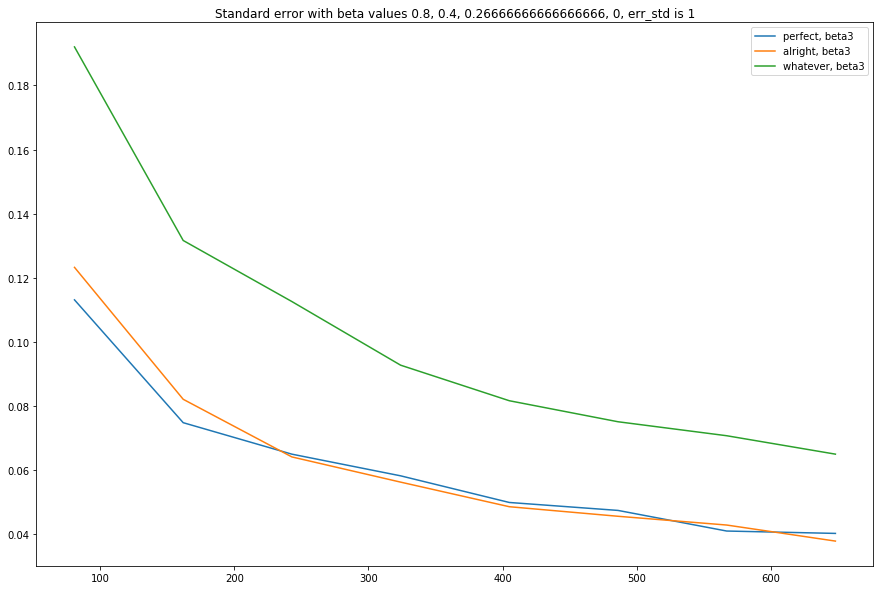

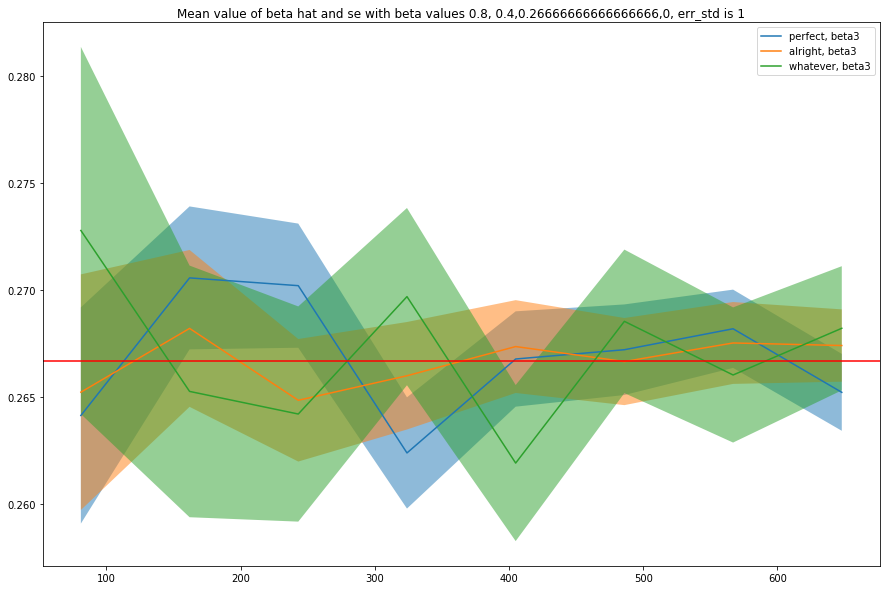

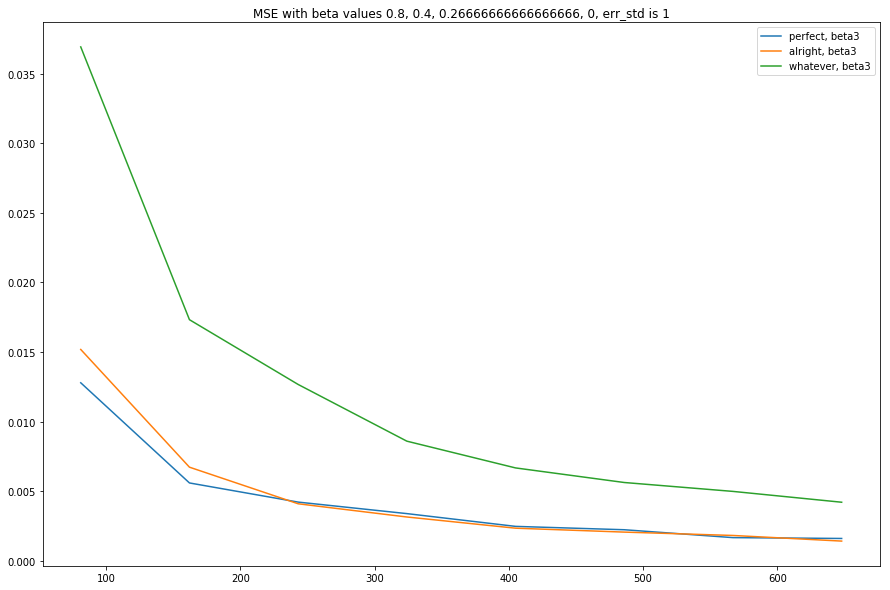

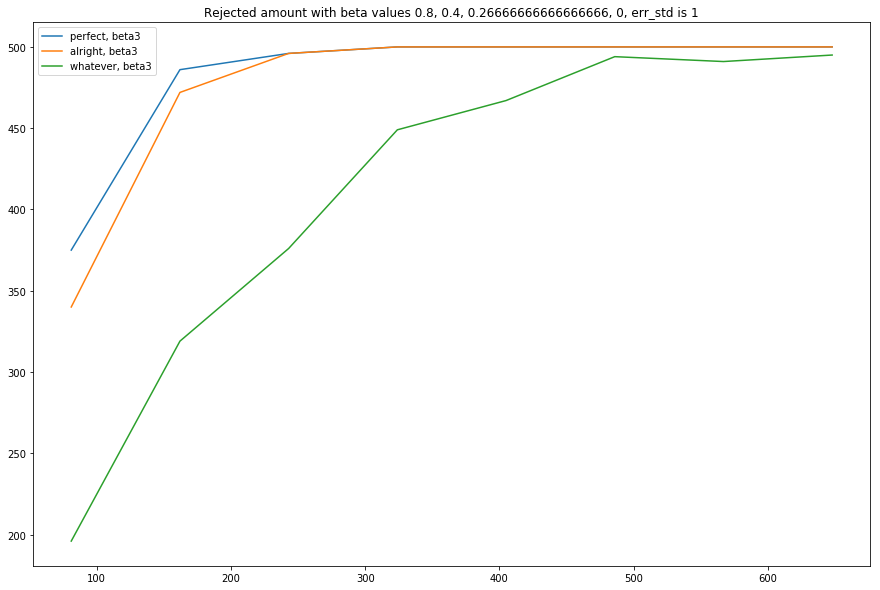

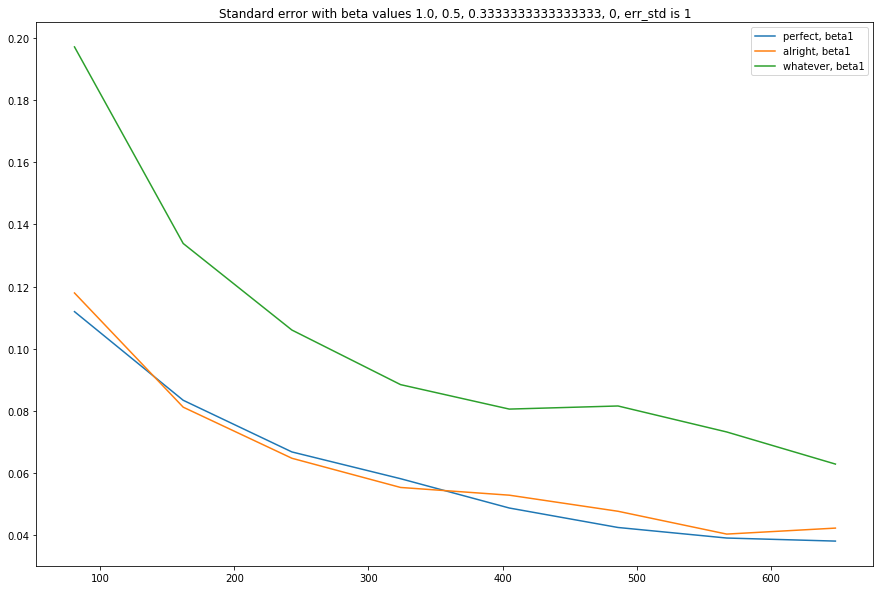

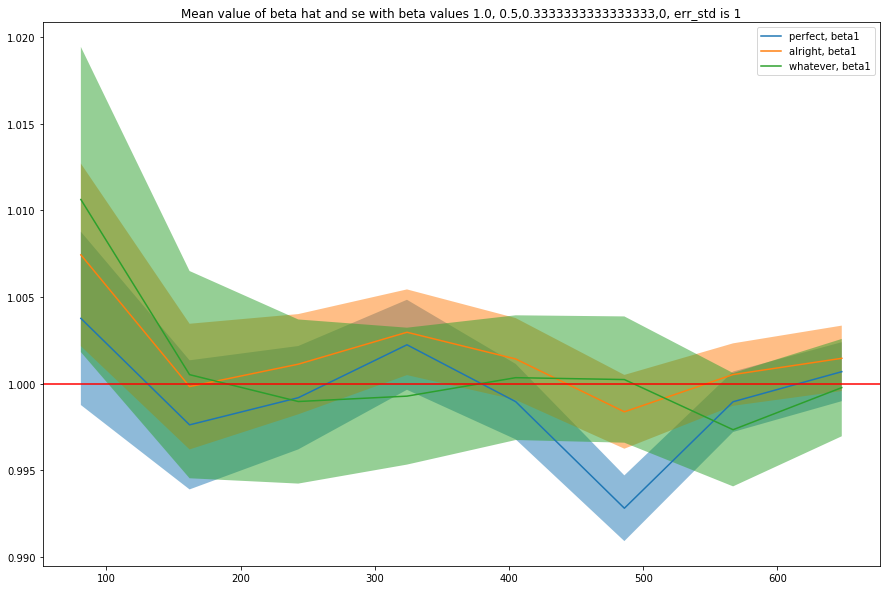

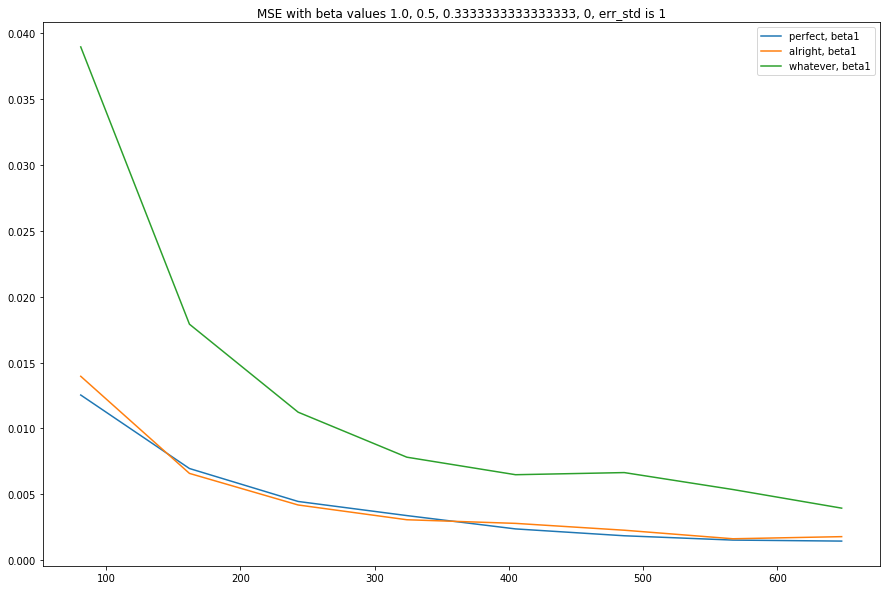

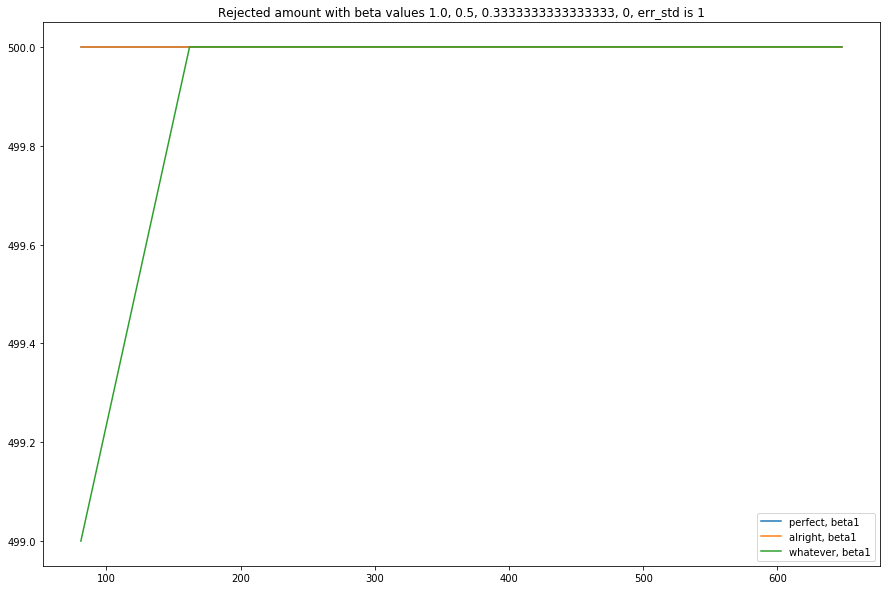

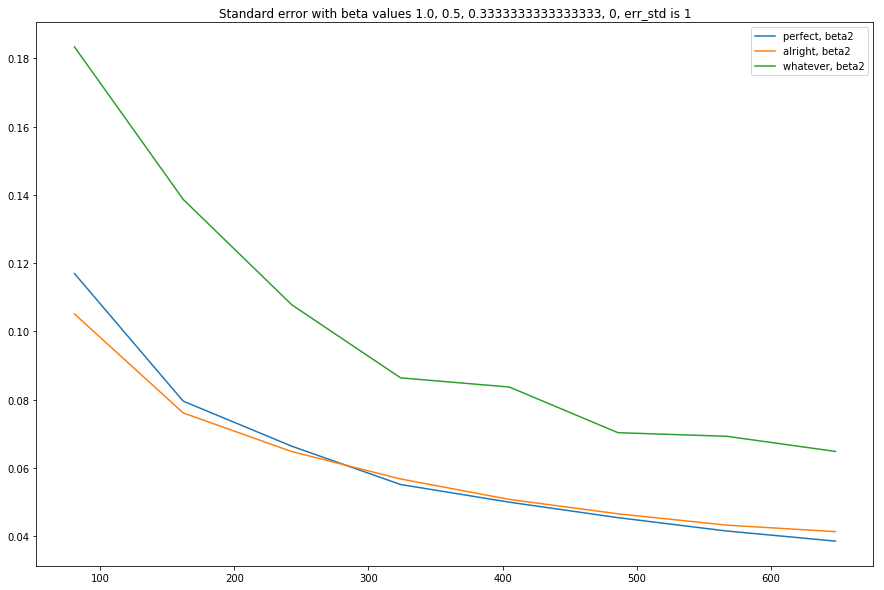

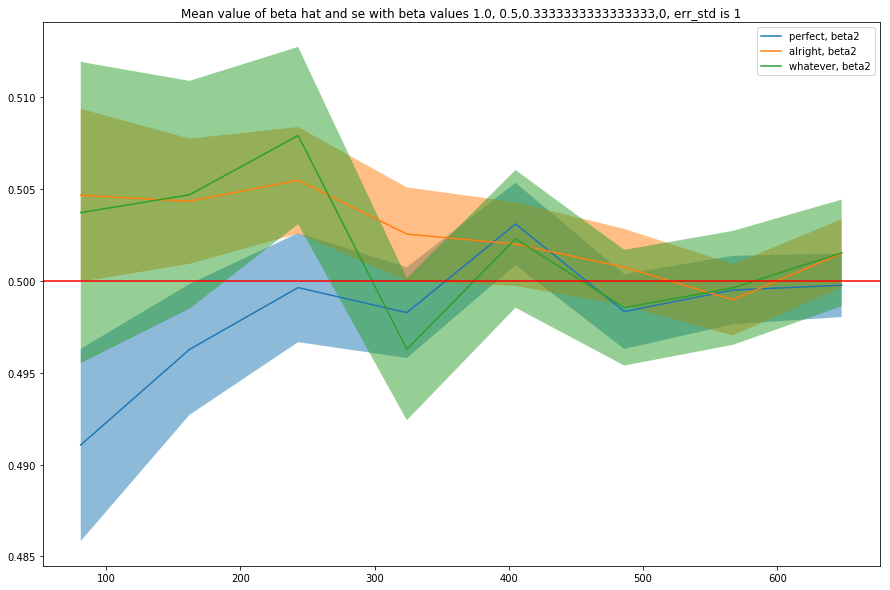

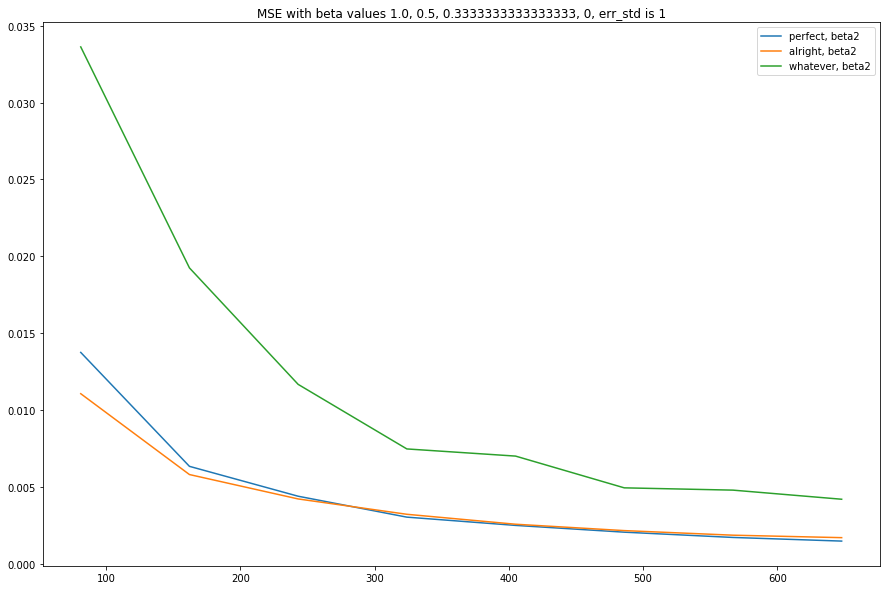

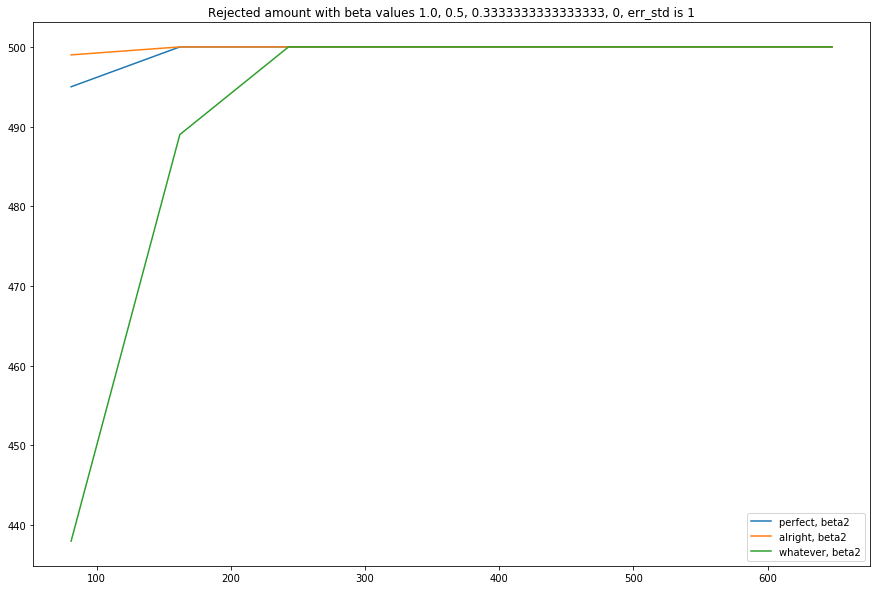

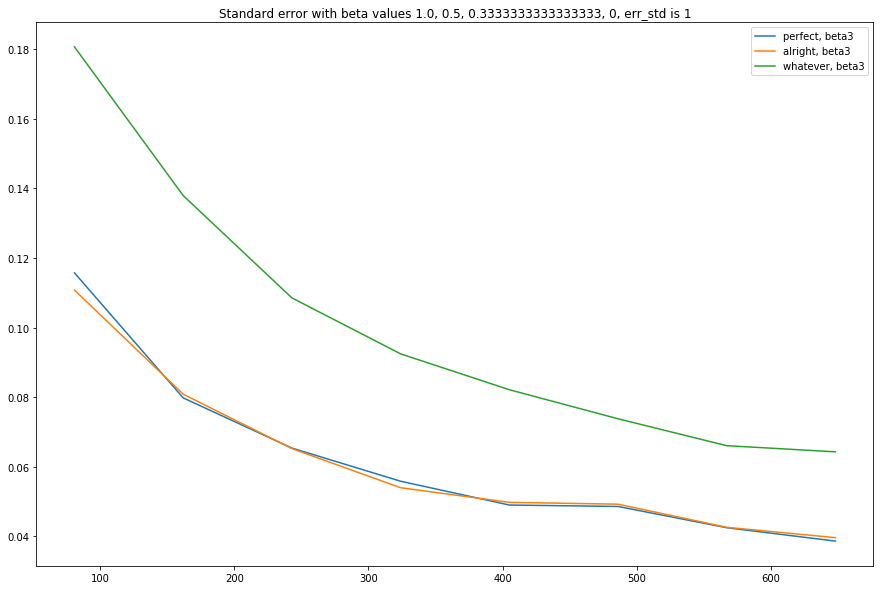

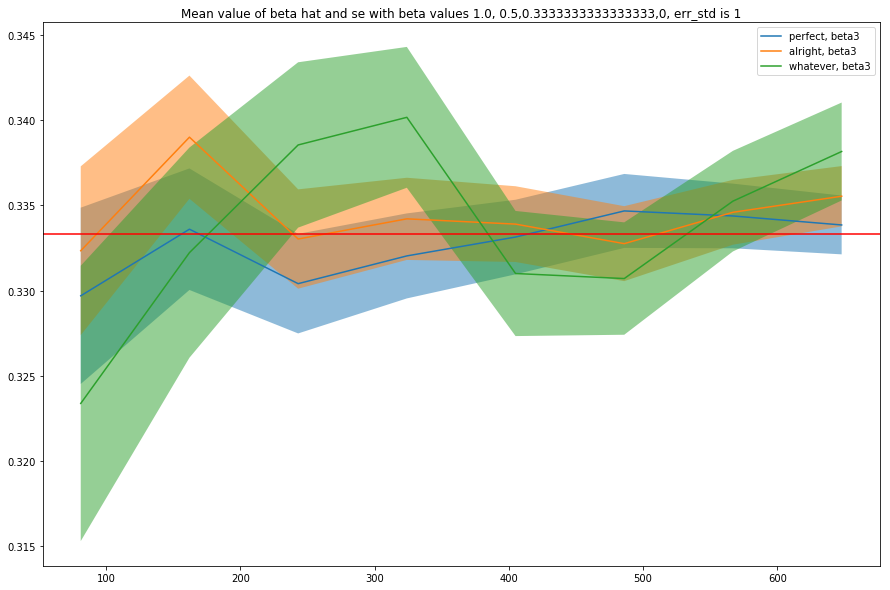

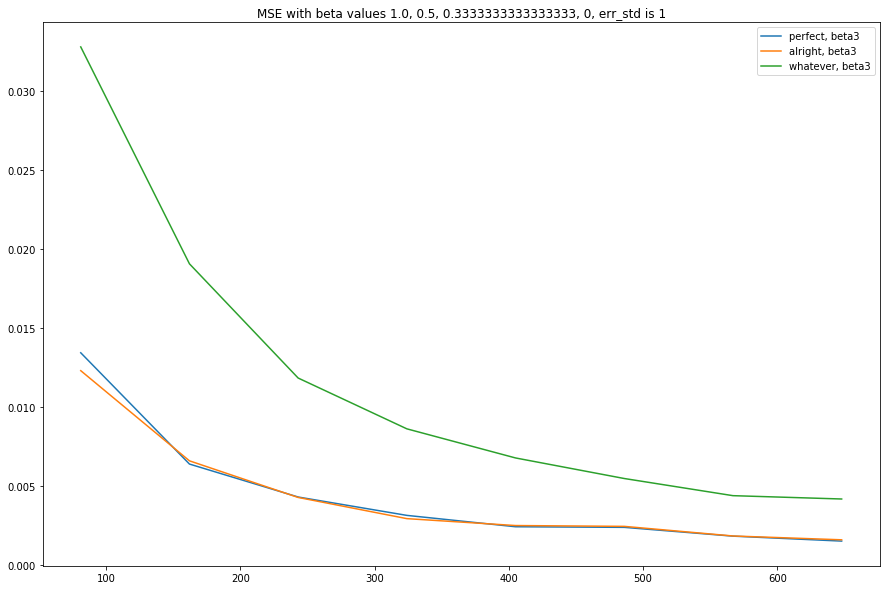

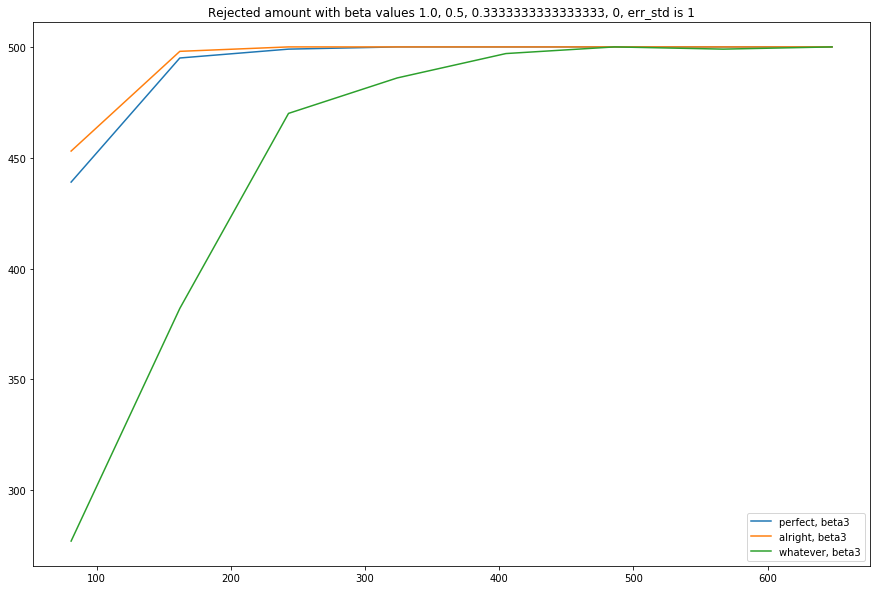

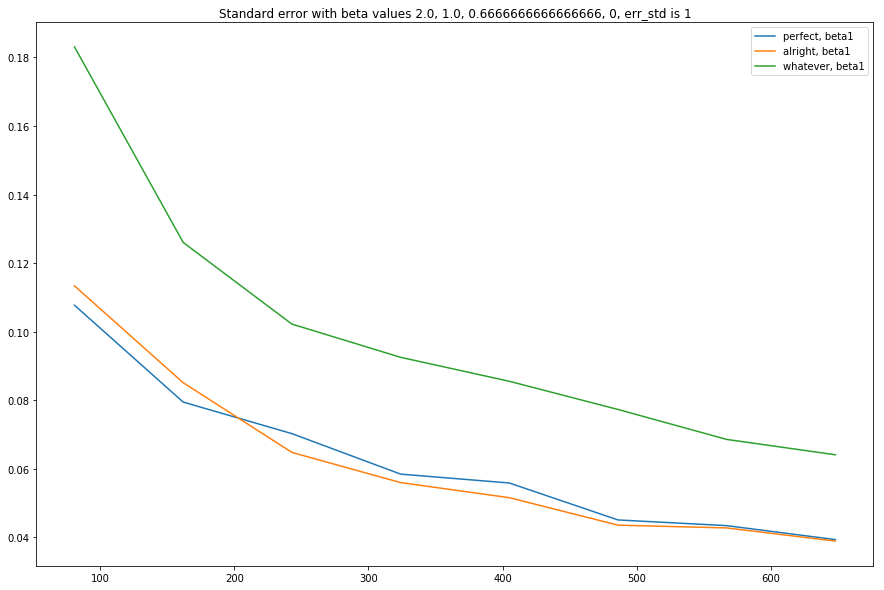

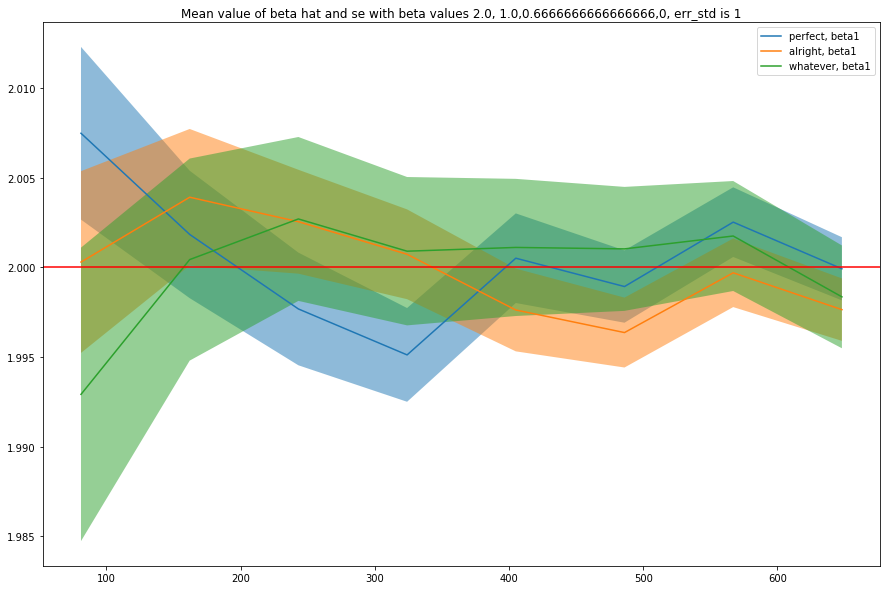

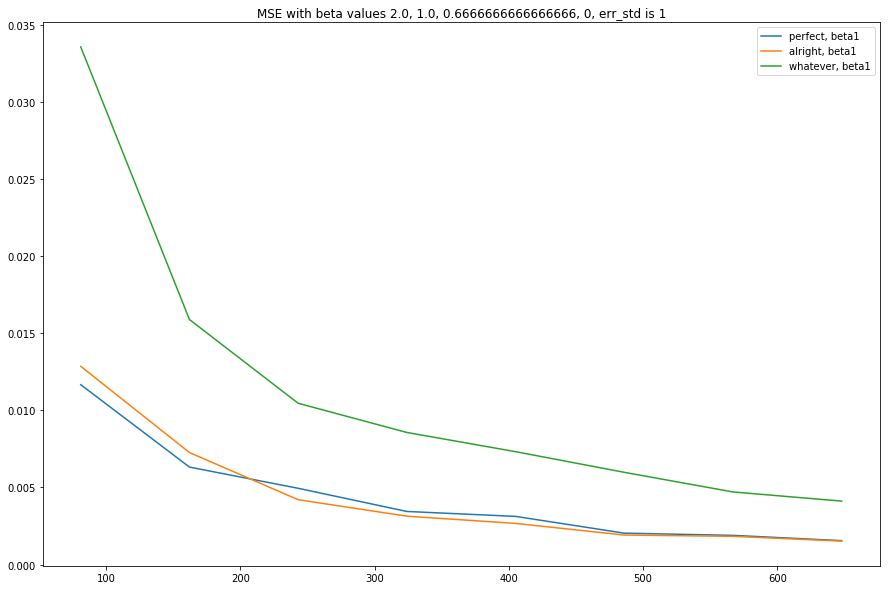

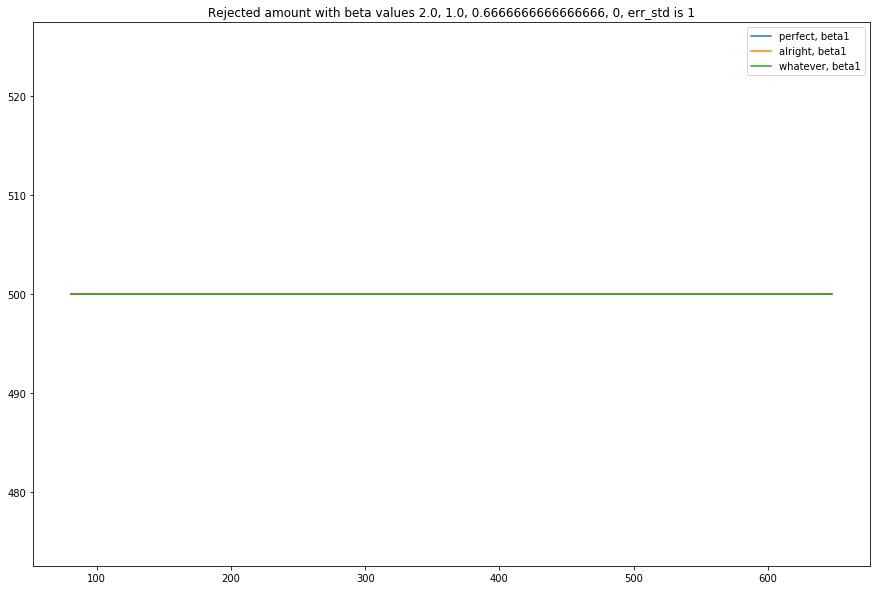

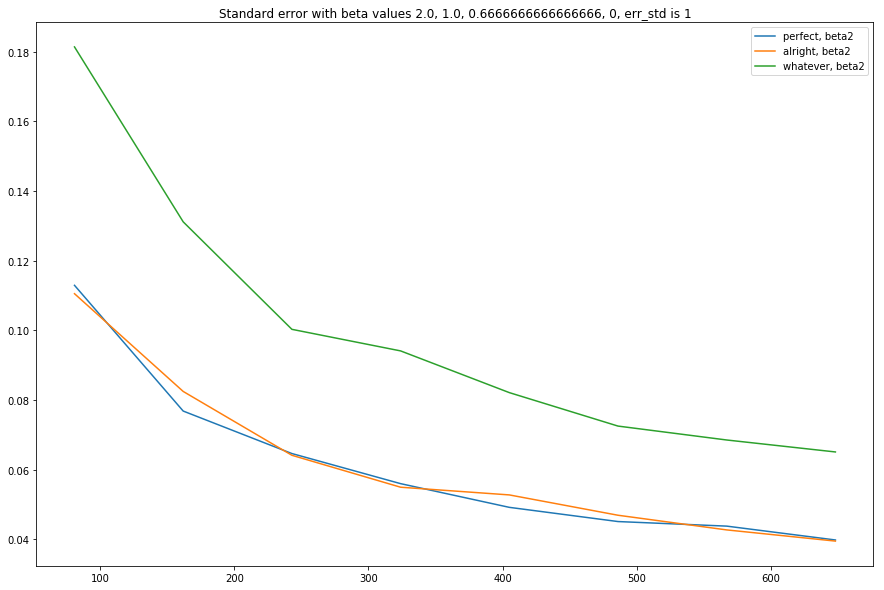

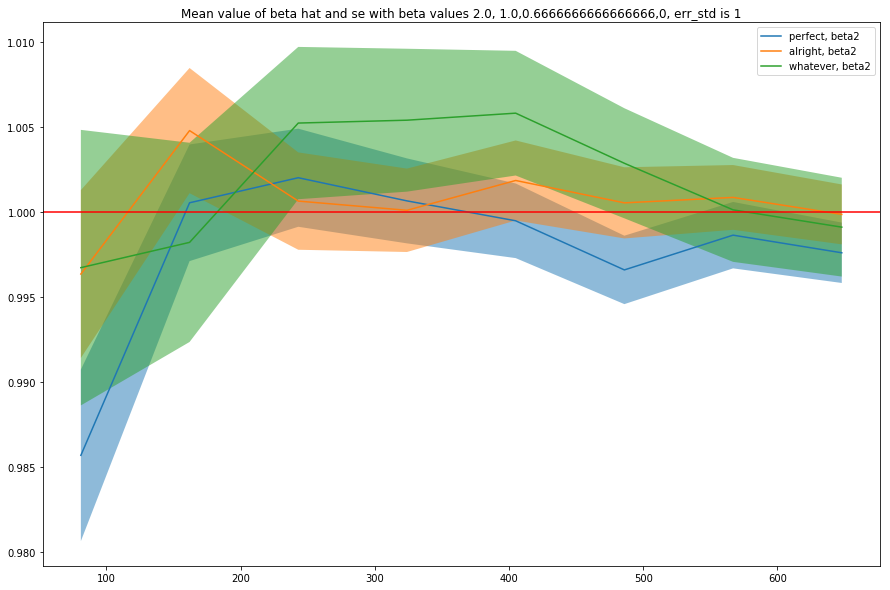

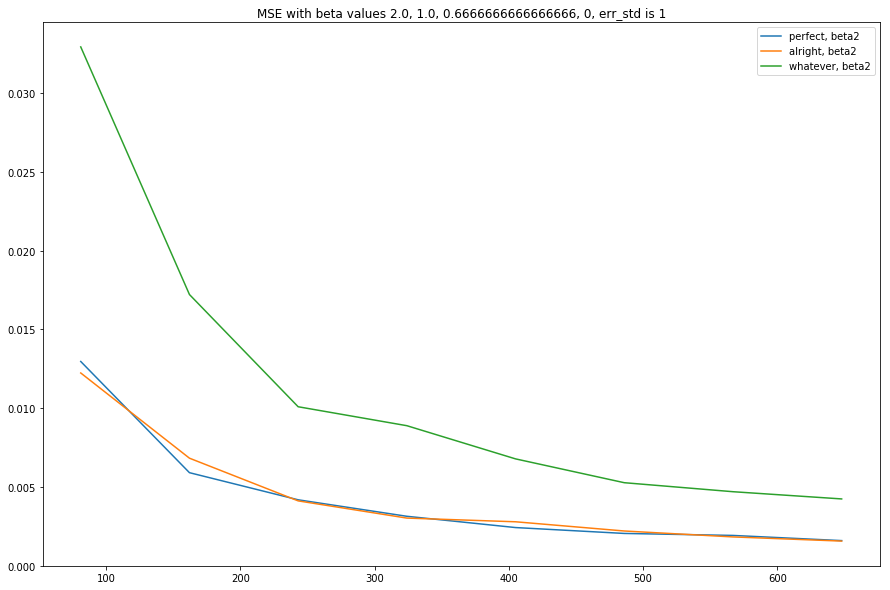

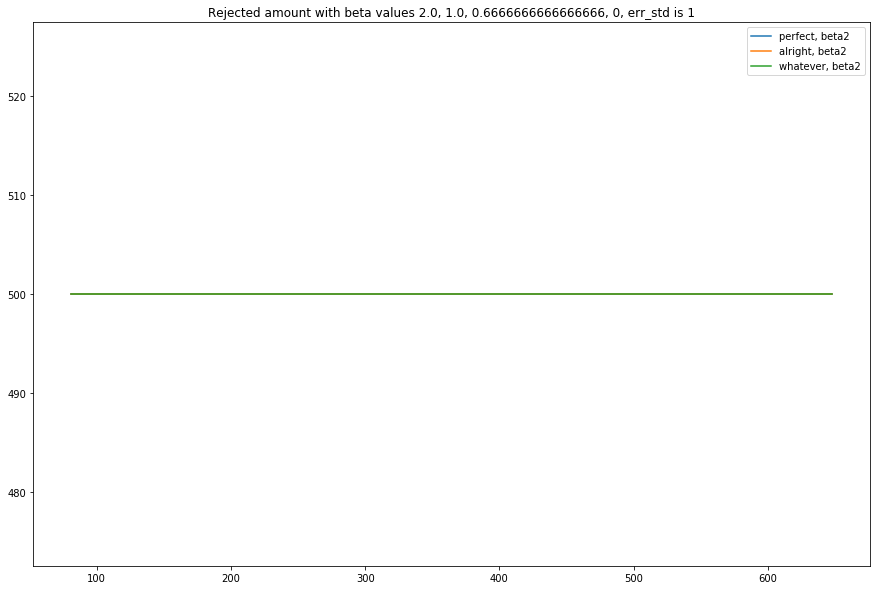

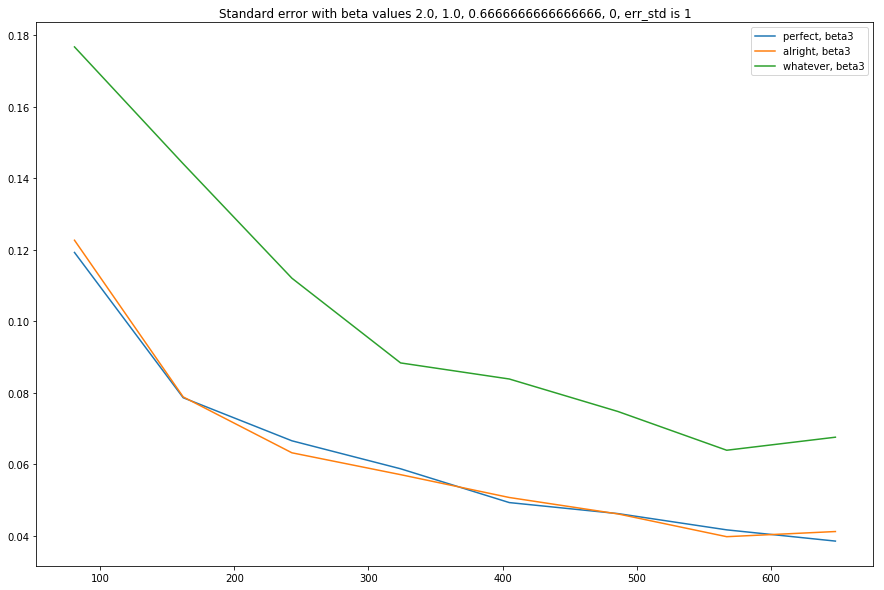

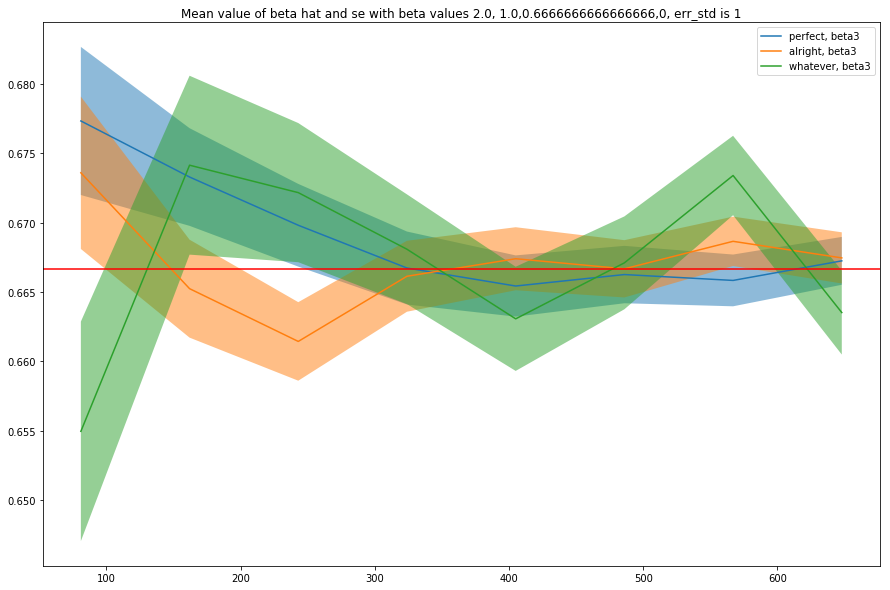

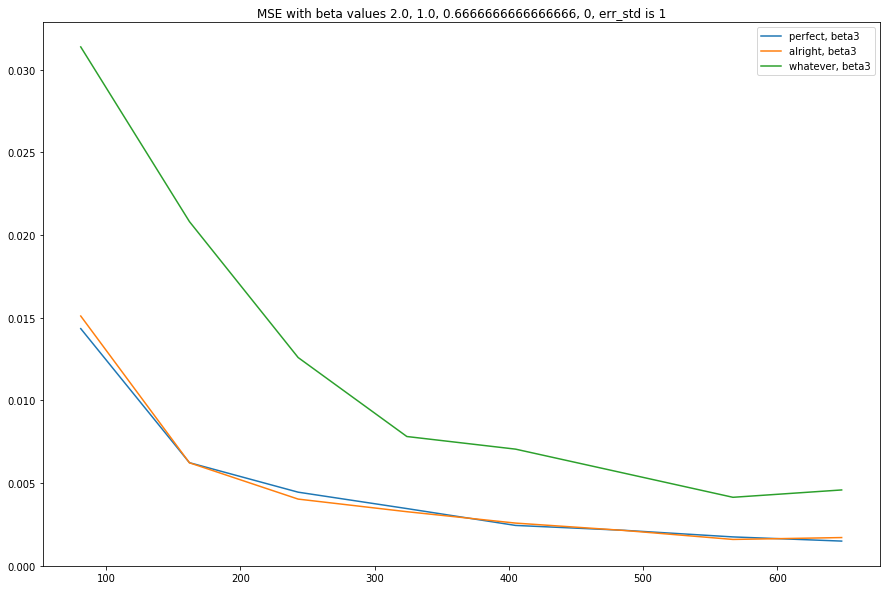

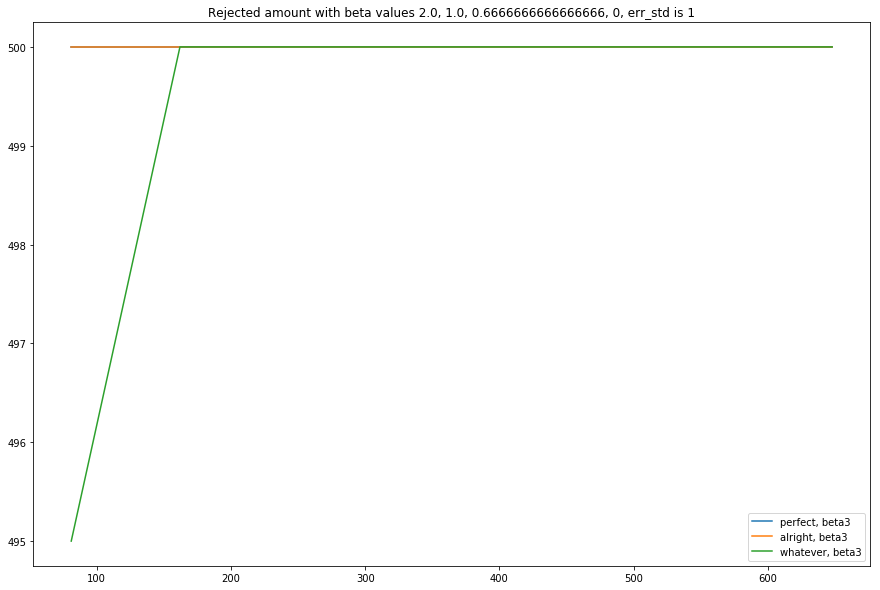

In [87]:
# Plot time!
alpha_list = [np.array([0.3, -0.3, 0.5]), np.array([0.5, -0.5, 0.7]), np.array([0.7, -0.7, 0.9]), 
              np.array([0.9, -0.9, 1.5]), np.array([1.5, -1.2, 2])]
beta_list = [alpha_list[i] / 2 for i in range(len(alpha_list))]
gamma_list = [alpha_list[i] / 3 for i in range(len(alpha_list))]

for i in range(len(alpha_list)):
    for j in range(1,9):
        draw_plot_trt3(alpha_list[i],beta_list[i], gamma_list[i], j)

In [57]:
np.random.normal(0, 1, 10)

array([-1.86466613, -0.0692446 ,  0.43286888, -0.63126008,  0.98257124,
       -0.36458738,  1.34951886, -1.32622976, -0.02419197,  1.35238417])